In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import h5py
import tqdm
import zipfile
from tqdm.notebook import tqdm_notebook
from progress.bar import IncrementalBar
import random
import pandas as pd
import time
import os
import math
from joblib import Parallel, delayed
# tf.config.run_functions_eagerly(True)
%matplotlib inline

In [2]:
param_names=['signal','pl_fr','real_wf-pl_fr','mask']

In [3]:
def norming(data,param_names=param_names,log=True):
    
    # ADD LOGARIFM FOR SIGNAL
    norm_params={}
    for i in range(data.shape[-1]):
        if (i==0 and log):
            data[:,:,:,i]=tf.math.log(data[:,:,:,i]+1)
        max_c=data[:,:,:,i].max()
        min_c=data[:,:,:,i].min()
        mean_c=data[:,:,:,i].mean()
        std_c=data[:,:,:,i].std()
        print(max_c,min_c)
        data[:,:,:,i]=(data[:,:,:,i]-min_c)/(max_c-min_c)

        norm_params[param_names[i]]=np.array([max_c,min_c])
    return norm_params
def renormin(data_not_change,norm_params,param_names=param_names,log=True):
    data=np.copy(data_not_change)
    for i in range(data.shape[-1]):
        max_c, min_c=norm_params[param_names[i]]
        data[:,:,:,i]=data[:,:,:,i]*(max_c-min_c) + min_c
        if (i==0 and log):
            data[:,:,:,i]=tf.math.exp(data[:,:,:,i])-1
        elif (i==1 or i==2):
            data[:,:,:,i]=data[:,:,:,i]*1e6
    return data

In [4]:
path='../../mc_hadrons_qgs34_0010.h5'
data_name='pr-q4-9yr'
data=np.zeros((1,6,6,4))
with h5py.File(path,'r') as f:
    data=np.concatenate((data,f[data_name]['dt'][:2000,:,:,3:7]))
    gp=f[data_name]['gp'].value
    ev_params=f[data_name]['ev_params'].value
data=data[1:]
data[:,:,:,1]=data[:,:,:,1]*1e6
data[:,:,:,2]=data[:,:,:,2]*1e6
print('len data: ',len(data))

/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/home/rfit/.conda/envs/robert_venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys


len data:  2000


In [ ]:
# new data


# Constant

In [5]:
pi = tf.constant(math.pi)
UNIT=1
dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
c=tf.constant(299792.458,dtype=tf.float32)# # km\s
NSEC= 1e6/c# in rubsov's code is a time for 1.2 km 1.2/c*1e9
R_L=30e-3
LINSLEY_r0=0.025
Det_Area=30
tf_type=tf.float32
s_min = tf.constant([[0.3]])
s_max = tf.constant([[1.8]])
t_err_res=c/1e6
t0_err=30

In [6]:
def reduce_saturation(data,ret_sig=True):
    max_signal=tf.reduce_max(data[:,:,:,0])
    signal=data[:,:,:,0]
    mask=data[:,:,:,3]
#     print('old signal \n',signal)
#     print('old mask \n',mask)
    new_mask=tf.where(tf.logical_and(mask!=0,signal==0),0,mask)
    new_signal=tf.where(tf.logical_and(mask!=0,signal==0),max_signal,signal)
    res=tf.where(tf.logical_and(mask!=0,signal==0),1,0)
    print(tf.reduce_sum(res))
    if ret_sig:
        return new_signal
    else:
        return new_mask

In [60]:
pi = tf.constant(math.pi)
UNIT=1
dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
c=tf.constant(299792.458,dtype=tf.float32)# # km\s
NSEC= 1e6/c# in rubsov's code is a time for 1.2 km 1.2/c*1e9
R_L=30e-3
LINSLEY_r0=0.025
Det_Area=30
tf_type=tf.float32
s_min = tf.constant([[0.3]])
s_max = tf.constant([[1.8]])
t_err_res=c/1e6
t0_err=30
class Reconstruction():
    #constants
    pi = tf.constant(math.pi)
    UNIT=1
    dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
    c=tf.constant(299792.458,dtype=tf.float32)# # km\s
    NSEC= 1e6/c# in rubsov's code is a time for 1.2 km 1.2/c*1e9
    R_L=30e-3
    LINSLEY_r0=0.025
    DET_AREA=3
    s_min = tf.constant([[0.3]])
    s_max = tf.constant([[1.8]])
    t_err_res=c/1e6
    t0_err=30
    dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
    
    def __init__(self,data,tf_type):
        # all have shape (batch,6,6,1)
        self.tf_type = tf_type
        self.data=tf.cast(data,self.tf_type)
        self.mask = tf.expand_dims(data[:,:,:,3],-1)
        self.signal = tf.expand_dims(data[:,:,:,0],-1)*self.mask
        self.mask = tf.where(self.signal==0,0,self.mask)
        self.real_time = tf.expand_dims((data[:,:,:,1] + data[:,:,:,2]),-1)*self.mask 
        self.signal = tf.cast(self.signal,self.tf_type)
        self.real_time = tf.cast(self.real_time,self.tf_type)
        self.mask = tf.cast(self.mask,self.tf_type)
        self.batch = data.shape[0]
        self.t0 = None
        self.theta = None
        self.detertors_coord = None
        self.core = None
        self.t_place = None
        self.courve = None
        self.R_error = 0.15
        self.S_X=None
        self.LDF=None
#     @classmethod
    def detectors_init(self):
        x = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),0),6,axis=0),self.tf_type)
        y = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),1),6,axis=1),self.tf_type)
        x = tf.expand_dims(x,-1)
        y = tf.expand_dims(y,-1)
        # x.shape = (6,6,1)
        detectors = tf.concat([x,y],axis=-1) * self.dist
        
        #detectors.shape = (batch,6,6,2) in km
        detectors = tf.repeat(tf.expand_dims(detectors,0),self.batch,0)
        self.detertors_coord=detectors
        return detectors
#     @classmethod
    def core_(self):
        detectors = self.detectors_init() # shape (batch,6,6,2)
        sum_signal=tf.reduce_sum(self.signal,axis=(1,2)) # shape (batch ,1)
        core=tf.reduce_sum(detectors * self.signal, axis=(1,2))/sum_signal
        #update self
        self.core = core
        return core
    @staticmethod
    def expand_dims(vec):
        return tf.expand_dims(tf.expand_dims(vec,-1),-1)
    def create_matrix(self,x,y,t,mask):
        a11=self.expand_dims(tf.reduce_sum(x*x,axis=1))
        a12=self.expand_dims(tf.reduce_sum(x*y,axis=1))
        a13=self.expand_dims(tf.reduce_sum(x,axis=1))
        a22=self.expand_dims(tf.reduce_sum(y*y,axis=1))
        a23=self.expand_dims(tf.reduce_sum(y,axis=1))
        a33=self.expand_dims(tf.reduce_sum(mask,axis=1))
        a1=tf.concat([a11,a12,a13],axis=2)
        a2=tf.concat([a12,a22,a23],axis=2)
        a3=tf.concat([a13,a23,a33],axis=2)
        A=tf.concat([a1,a2,a3],axis=1)

        b1=self.expand_dims(tf.reduce_sum(x*t,axis=1))
        b2=self.expand_dims(tf.reduce_sum(y*t,axis=1))
        b3=self.expand_dims(tf.reduce_sum(t,axis=1))
        b=tf.concat([b1,b2,b3],axis=1)
        return A,b
    def place_sol(self):
        real_time=self.real_time
        mask=self.mask
        detectors = self.detectors_init() * mask
        x = tf.reshape(detectors[:,:,:,0],(-1,36))
        y = tf.reshape(detectors[:,:,:,1],(-1,36))
        t = tf.reshape(real_time,(-1,36))
        mask = tf.reshape(mask,(-1,36))
        A,b=self.create_matrix(x,y,t,mask)
        return tf.linalg.solve(A,b)
#     @classmethod
    def place_params(self):
        sol = self.place_sol()
        #t_0=b+(r_cor;n)
        b=sol[:,2:,0]
        n=sol[:,:2,0]
        core = self.core_()
        mul=n[:,0]*core[:,0]+n[:,1]*core[:,1]
#         t0 = tf.cast(tf.expand_dims(b,1)+tf.expand_dims(mul,1),dtype=self.tf_type)
        t0=b
        a_x=n[:,0]
        a_y=n[:,1]
        a_z=tf.math.pow(1e6/c,2) - (tf.math.pow(a_x,2) + tf.math.pow(a_y,2))
        a_z=tf.where(a_z>0,tf.math.sqrt(a_z),0)
        cos_theta=a_z*(c/1e6)
        theta=tf.math.acos(cos_theta)
        tg_phi=a_x/(-a_y)
        atan=tf.math.atan(tg_phi)
        phi=tf.where(a_y>0,atan+pi,atan-pi)
        phi=tf.where(a_x<0,atan,phi)
        phi = tf.math.atan2( -a_x, -a_y )
        # update self
        self.phi = phi
        self.theta = theta
        self.t0=t0
        return t0,tf.expand_dims(theta,-1),tf.expand_dims(phi,-1)
    def detectors_core(self):
        detectors=self.detertors_coord
        core = self.core
        detectors_c=detectors-tf.reshape(core,(-1,1,1,2))
        return detectors_c
#     @classmethod
    def place_reconstruction(self):
        t0,theta,phi = self.place_params()
        detectors = self.detectors_core()
        detectors = self.detertors_coord
#         print(detectors)
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)*(1e6/c)
#         print(n)
        t_place =  t0 + detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        t_place = t_place*self.mask
        self.t_place = t_place*self.mask
        return self.t_place
    def place_reconstruction_static(self,t0,theta,phi):
        detectors = self.detectors_core()
        detectors = self.detertors_coord
#         print(detectors)
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)*(1e6/c)
#         print(n)
        t_place =  t0 + detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        t_place = t_place*self.mask
        self.t_place = t_place*self.mask
        return self.t_place
    @staticmethod
    def eta_fun(theta):
        x=theta*180/3.14

        e1 = 3.97 - 1.79*(tf.math.abs(1.0/tf.math.cos(theta)) - 1.0)
        e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
                   + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
                 + 3.70692527e+00)
        res = tf.where(x<62.7,e1,e2)
        # check
        res =tf.where(res>0,res,0)
        return res
    def s_profile_tasimple(self,r_ta,theta):
        r = r_ta*UNIT
        eta=self.eta_fun(theta)# batch,1,1
        eta=tf.repeat(eta,6,axis=1)
        eta=tf.repeat(eta,6,axis=2)
        # eta shape is batch,6,6
        Rm = tf.constant(0.09,dtype=tf.float32)
        R1 = tf.constant(1,dtype=tf.float32)
        return (tf.math.pow((r/Rm),-1.2)*tf.math.pow((1+r/Rm), -(eta-1.2))*tf.math.pow(1+(tf.math.pow(r,2)/R1/R1),-0.6))
    def s_profile(self,r_ta, theta):
        #r_ta shape batch,6,6
        f800=self.s_profile_tasimple(self.expand_dims(tf.constant(0.8)), theta)
        return self.s_profile_tasimple(r_ta, theta)/f800
    def pfs__pps(self):
        t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core()
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2] # not has t0
        # end t_place's part
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
        cond_dist = tf.cast(tf.where(tf.logical_and(dist_core>s_min,dist_core<s_max),self.mask,0.),tf_type)
        pfs = tf.reduce_sum(self.signal*cond_dist,axis=(1,2))
        pps = tf.reduce_sum(self.s_profile(dist_core,theta)*cond_dist,axis=(1,2))
        # might update self
        return (pfs,pps)
    @staticmethod
    def a_ivanov_fun(theta):
        DEG=pi/180
        threshold1=25*DEG
        threshold2=35*DEG
        # переписать для обнавления масива
        res1=tf.where(theta<threshold1,3.3836 - 0.01848*theta/DEG,0)
        res3=tf.where(theta>threshold2,tf.math.exp(-3.2e-2*theta/DEG + 2.0),0)
        a=(0.6511268210e-4*(theta/DEG-0.2614963683))*(theta/DEG*theta/DEG-134.7902422*theta/DEG+4558.524091)
        res2=tf.where(tf.math.logical_and(theta > threshold1,theta < threshold2),a,0)
        return res1+res2+res3
    
    def courve_fun(self):
        a_ivanov = self.a_ivanov_fun(self.theta)
        pfs,pps = self.pfs__pps()
        # norming
        S_X = tf.where(pps>1e-10,pfs/pps,1)[:,0]
        self.S_X=tf.expand_dims(S_X,-1)
        courve = tf.expand_dims(a_ivanov*1.3/tf.math.sqrt(S_X),axis=-1)
        self.courve = courve
        return courve
    @staticmethod
    def linsley_t(r,S):
        return 0.67*tf.math.pow((1 + r/LINSLEY_r0), 1.5)*tf.math.pow(S, -0.5)/1e3
    def courve_reconstruction(self):
        t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core()
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
        LDF=self.s_profile(dist_core,theta)
        self.LDF=LDF
        td=self.expand_dims(self.courve)*self.linsley_t(dist_core,LDF)/NSEC
        return td
    def courve_reconstruction_static(self,t0,theta,phi,courve):
        t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core()
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        # add R-error
        dist_core = tf.where(dist_core>self.R_error*self.R_error,tf.math.sqrt(dist_core),self.R_error)
        cond_dist = tf.cast(tf.where(tf.logical_and(dist_core>s_min,dist_core<s_max),self.mask,0.),tf_type)
        LDF=self.s_profile(dist_core,theta)#*cond_dist
        self.LDF=LDF
        td=self.expand_dims(courve)*self.linsley_t(dist_core,LDF)/NSEC
        return td,LDF
    @staticmethod
    def logPua(n,nbar):
        print(n.shape,nbar.shape)
        last_part = 2*(n*tf.math.log(nbar/(n+1e-8)) + (n - nbar))

        nbar_logical=tf.where(nbar < 1e-90,True,False)
        n_logical1 = tf.where(n>1e-90,True,False)
        res = tf.zeros_like(n)
        res=tf.where(tf.logical_and(nbar_logical,n_logical1),-1e-6,res)

        else_nbar_logical = tf.logical_not(nbar_logical) 
        n_logical2 = tf.where(n<1e-20,True,False)

        res=tf.where(tf.logical_and(else_nbar_logical,n_logical2),-2*nbar,res)
        res=tf.where(tf.logical_and(else_nbar_logical,tf.logical_not(n_logical2)),last_part,res)
        return res
    def chi2L(self,S_X,s_prof):
        mask=self.mask
        s_fit = self.expand_dims(S_X)*s_prof*mask
#         print('SX',self.expand_dims(S_X),'\ns_prof',s_prof[:,:,:,0],'\n sift',s_fit[:,:,:,0])
        qs=self.signal
        s_sigma2 = ( 2*qs/self.DET_AREA + tf.math.pow( 0.15*qs, 2 ) + 1e-6 )
        maskL2 = tf.where(qs>4.0,mask,0)
        S=S_X
#         print(s_fit[:,:,:,0],qs[:,:,:,0])
        chi2L2=tf.reduce_sum((qs - s_fit)*(qs - s_fit)/s_sigma2*maskL2,axis=(1,2))
        maskL3 = tf.where(s_fit<4.0,mask,0)
#         chi2L3 = -tf.reduce_sum(0.4*self.logPua(S*self.DET_AREA, s_fit*self.DET_AREA)*maskL3,axis=(1,2))
#         print(chi2L2.shape,chi3L.shape)
        return chi2L2  #+ chi3L
    def optimization(self,iterats,alpha=0.1):
        # add ch2_L
        self.detectors_init()
        self.core_()
        self.place_sol()
        # ??? don't work without that 
        pfs,pps= rec.pfs__pps()
        rec.courve_fun()
        chi_list=[]
        self.place_params()
        t0=self.t0
        theta=tf.expand_dims(self.theta,-1)
        phi=tf.expand_dims(self.phi,-1)
        core = self.core
        courve= self.courve
        S_X = self.S_X
#         print(S_X)
        params=tf.concat([t0,theta,phi,courve,core,S_X],axis=1)
    
        
        params_list=[]
        params_list.append(params)
        for i in range(iterats):
            with tf.GradientTape() as gr:  
                gr.watch(params)
                self.t0=params[:,0:1]
                self.theta=params[:,1:2]
                self.phi=params[:,2:3]
                self.courve=params[:,3:4]
                self.core=params[:,4:6]
                self.S_X=params[:,6:7]
                
                t0=params[:,0:1]
                theta=params[:,1:2]
                phi=params[:,2:3]
                courve=params[:,3:4]
                S_X=params[:,6:7]
#                 print(i,S_X)
                t_place = self.place_reconstruction_static(t0,theta,phi)
                td,LDF = self.courve_reconstruction_static(t0,theta,phi,courve)  #update LDF <==> s_profile
                t_sigma2=(t0_err*t0_err + td*td) * t_err_res
                time_reco = t_place +td
                chi_T=tf.reduce_sum(tf.math.pow((time_reco-self.real_time)*self.mask,2)/t_sigma2,axis=(1,2))
                chi_L=self.chi2L(S_X,LDF)
                chi = chi_T +chi_L
                print(tf.reduce_mean(chi_L),tf.reduce_mean(S_X),end='\n')
                chi_list.append(chi)
                grad=gr.gradient(chi,params)
#                 print('grad',grad)
                params=params-alpha*grad
                # updating
                self.t0=params[:,0:1]
                self.theta=params[:,1:2]
                self.phi=params[:,2:3]
                self.courve=params[:,3:4]
                self.core=params[:,4:]
                self.S_X=params[:,6:7]
                params_list.append(params)
        return np.array(chi_list),np.array(params_list)

In [63]:
rec = Reconstruction(data[:10],tf.float32)
# det=rec.detectors_init()
# core=rec.core_()
# sol = rec.place_sol() 
# sol
chi,params=rec.optimization(1000,alpha=0.0001)

tf.Tensor(4141.6143, shape=(), dtype=float32) tf.Tensor(6.1942806, shape=(), dtype=float32)
tf.Tensor(3822.8516, shape=(), dtype=float32) tf.Tensor(6.126493, shape=(), dtype=float32)
tf.Tensor(3531.4663, shape=(), dtype=float32) tf.Tensor(6.0613527, shape=(), dtype=float32)
tf.Tensor(3265.048, shape=(), dtype=float32) tf.Tensor(5.998742, shape=(), dtype=float32)
tf.Tensor(3021.398, shape=(), dtype=float32) tf.Tensor(5.9385505, shape=(), dtype=float32)
tf.Tensor(2798.5142, shape=(), dtype=float32) tf.Tensor(5.8806725, shape=(), dtype=float32)
tf.Tensor(2594.5703, shape=(), dtype=float32) tf.Tensor(5.825006, shape=(), dtype=float32)
tf.Tensor(2407.9026, shape=(), dtype=float32) tf.Tensor(5.7714562, shape=(), dtype=float32)
tf.Tensor(2236.9934, shape=(), dtype=float32) tf.Tensor(5.7199287, shape=(), dtype=float32)
tf.Tensor(2080.4607, shape=(), dtype=float32) tf.Tensor(5.6703367, shape=(), dtype=float32)
tf.Tensor(1937.044, shape=(), dtype=float32) tf.Tensor(5.6225963, shape=(), dtype=flo

tf.Tensor(115.54016, shape=(), dtype=float32) tf.Tensor(4.2038217, shape=(), dtype=float32)
tf.Tensor(113.47002, shape=(), dtype=float32) tf.Tensor(4.198376, shape=(), dtype=float32)
tf.Tensor(111.440445, shape=(), dtype=float32) tf.Tensor(4.1930013, shape=(), dtype=float32)
tf.Tensor(109.45048, shape=(), dtype=float32) tf.Tensor(4.187695, shape=(), dtype=float32)
tf.Tensor(107.49917, shape=(), dtype=float32) tf.Tensor(4.1824555, shape=(), dtype=float32)
tf.Tensor(105.585655, shape=(), dtype=float32) tf.Tensor(4.177282, shape=(), dtype=float32)
tf.Tensor(103.70908, shape=(), dtype=float32) tf.Tensor(4.172173, shape=(), dtype=float32)
tf.Tensor(101.86862, shape=(), dtype=float32) tf.Tensor(4.1671267, shape=(), dtype=float32)
tf.Tensor(100.06343, shape=(), dtype=float32) tf.Tensor(4.1621413, shape=(), dtype=float32)
tf.Tensor(98.29279, shape=(), dtype=float32) tf.Tensor(4.1572165, shape=(), dtype=float32)
tf.Tensor(96.55593, shape=(), dtype=float32) tf.Tensor(4.1523504, shape=(), dtype=f

tf.Tensor(22.528309, shape=(), dtype=float32) tf.Tensor(3.8726578, shape=(), dtype=float32)
tf.Tensor(22.199219, shape=(), dtype=float32) tf.Tensor(3.8706203, shape=(), dtype=float32)
tf.Tensor(21.876192, shape=(), dtype=float32) tf.Tensor(3.8686008, shape=(), dtype=float32)
tf.Tensor(21.559109, shape=(), dtype=float32) tf.Tensor(3.8665996, shape=(), dtype=float32)
tf.Tensor(21.247862, shape=(), dtype=float32) tf.Tensor(3.8646157, shape=(), dtype=float32)
tf.Tensor(20.942348, shape=(), dtype=float32) tf.Tensor(3.8626494, shape=(), dtype=float32)
tf.Tensor(20.64246, shape=(), dtype=float32) tf.Tensor(3.8607001, shape=(), dtype=float32)
tf.Tensor(20.34809, shape=(), dtype=float32) tf.Tensor(3.858768, shape=(), dtype=float32)
tf.Tensor(20.059137, shape=(), dtype=float32) tf.Tensor(3.856853, shape=(), dtype=float32)
tf.Tensor(19.775505, shape=(), dtype=float32) tf.Tensor(3.854955, shape=(), dtype=float32)
tf.Tensor(19.497091, shape=(), dtype=float32) tf.Tensor(3.8530731, shape=(), dtype=fl

tf.Tensor(7.5370665, shape=(), dtype=float32) tf.Tensor(3.7374663, shape=(), dtype=float32)
tf.Tensor(7.483594, shape=(), dtype=float32) tf.Tensor(3.7365832, shape=(), dtype=float32)
tf.Tensor(7.4310975, shape=(), dtype=float32) tf.Tensor(3.7357075, shape=(), dtype=float32)
tf.Tensor(7.379565, shape=(), dtype=float32) tf.Tensor(3.734839, shape=(), dtype=float32)
tf.Tensor(7.3289747, shape=(), dtype=float32) tf.Tensor(3.733977, shape=(), dtype=float32)
tf.Tensor(7.2793093, shape=(), dtype=float32) tf.Tensor(3.7331226, shape=(), dtype=float32)
tf.Tensor(7.2305527, shape=(), dtype=float32) tf.Tensor(3.7322745, shape=(), dtype=float32)
tf.Tensor(7.1826873, shape=(), dtype=float32) tf.Tensor(3.7314343, shape=(), dtype=float32)
tf.Tensor(7.1356993, shape=(), dtype=float32) tf.Tensor(3.7306004, shape=(), dtype=float32)
tf.Tensor(7.08957, shape=(), dtype=float32) tf.Tensor(3.7297733, shape=(), dtype=float32)
tf.Tensor(7.0442834, shape=(), dtype=float32) tf.Tensor(3.728953, shape=(), dtype=floa

tf.Tensor(5.0863276, shape=(), dtype=float32) tf.Tensor(3.677072, shape=(), dtype=float32)
tf.Tensor(5.0774126, shape=(), dtype=float32) tf.Tensor(3.6766586, shape=(), dtype=float32)
tf.Tensor(5.068656, shape=(), dtype=float32) tf.Tensor(3.6762478, shape=(), dtype=float32)
tf.Tensor(5.0600553, shape=(), dtype=float32) tf.Tensor(3.6758404, shape=(), dtype=float32)
tf.Tensor(5.0516076, shape=(), dtype=float32) tf.Tensor(3.6754355, shape=(), dtype=float32)
tf.Tensor(5.0433097, shape=(), dtype=float32) tf.Tensor(3.675034, shape=(), dtype=float32)
tf.Tensor(5.0351586, shape=(), dtype=float32) tf.Tensor(3.6746354, shape=(), dtype=float32)
tf.Tensor(5.027152, shape=(), dtype=float32) tf.Tensor(3.6742387, shape=(), dtype=float32)
tf.Tensor(5.019288, shape=(), dtype=float32) tf.Tensor(3.6738458, shape=(), dtype=float32)
tf.Tensor(5.0115623, shape=(), dtype=float32) tf.Tensor(3.673455, shape=(), dtype=float32)
tf.Tensor(5.003974, shape=(), dtype=float32) tf.Tensor(3.6730676, shape=(), dtype=floa

tf.Tensor(4.665008, shape=(), dtype=float32) tf.Tensor(3.647325, shape=(), dtype=float32)
tf.Tensor(4.6633244, shape=(), dtype=float32) tf.Tensor(3.6471057, shape=(), dtype=float32)
tf.Tensor(4.6616664, shape=(), dtype=float32) tf.Tensor(3.6468875, shape=(), dtype=float32)
tf.Tensor(4.6600347, shape=(), dtype=float32) tf.Tensor(3.6466706, shape=(), dtype=float32)
tf.Tensor(4.658427, shape=(), dtype=float32) tf.Tensor(3.6464546, shape=(), dtype=float32)
tf.Tensor(4.6568437, shape=(), dtype=float32) tf.Tensor(3.6462398, shape=(), dtype=float32)
tf.Tensor(4.655284, shape=(), dtype=float32) tf.Tensor(3.6460261, shape=(), dtype=float32)
tf.Tensor(4.653749, shape=(), dtype=float32) tf.Tensor(3.6458142, shape=(), dtype=float32)
tf.Tensor(4.652236, shape=(), dtype=float32) tf.Tensor(3.6456032, shape=(), dtype=float32)
tf.Tensor(4.6507473, shape=(), dtype=float32) tf.Tensor(3.645393, shape=(), dtype=float32)
tf.Tensor(4.6492796, shape=(), dtype=float32) tf.Tensor(3.6451843, shape=(), dtype=floa

tf.Tensor(4.5742826, shape=(), dtype=float32) tf.Tensor(3.6303291, shape=(), dtype=float32)
tf.Tensor(4.573791, shape=(), dtype=float32) tf.Tensor(3.630191, shape=(), dtype=float32)
tf.Tensor(4.573304, shape=(), dtype=float32) tf.Tensor(3.6300538, shape=(), dtype=float32)
tf.Tensor(4.5728216, shape=(), dtype=float32) tf.Tensor(3.6299171, shape=(), dtype=float32)
tf.Tensor(4.5723424, shape=(), dtype=float32) tf.Tensor(3.6297805, shape=(), dtype=float32)
tf.Tensor(4.571868, shape=(), dtype=float32) tf.Tensor(3.629645, shape=(), dtype=float32)
tf.Tensor(4.571398, shape=(), dtype=float32) tf.Tensor(3.6295097, shape=(), dtype=float32)
tf.Tensor(4.5709314, shape=(), dtype=float32) tf.Tensor(3.629375, shape=(), dtype=float32)
tf.Tensor(4.570469, shape=(), dtype=float32) tf.Tensor(3.6292408, shape=(), dtype=float32)
tf.Tensor(4.57001, shape=(), dtype=float32) tf.Tensor(3.629107, shape=(), dtype=float32)
tf.Tensor(4.5695553, shape=(), dtype=float32) tf.Tensor(3.6289737, shape=(), dtype=float32)

tf.Tensor(4.539076, shape=(), dtype=float32) tf.Tensor(3.6187794, shape=(), dtype=float32)
tf.Tensor(4.538797, shape=(), dtype=float32) tf.Tensor(3.6186771, shape=(), dtype=float32)
tf.Tensor(4.538518, shape=(), dtype=float32) tf.Tensor(3.6185753, shape=(), dtype=float32)
tf.Tensor(4.5382395, shape=(), dtype=float32) tf.Tensor(3.6184738, shape=(), dtype=float32)
tf.Tensor(4.537963, shape=(), dtype=float32) tf.Tensor(3.618372, shape=(), dtype=float32)
tf.Tensor(4.537687, shape=(), dtype=float32) tf.Tensor(3.6182714, shape=(), dtype=float32)
tf.Tensor(4.537412, shape=(), dtype=float32) tf.Tensor(3.6181703, shape=(), dtype=float32)
tf.Tensor(4.537137, shape=(), dtype=float32) tf.Tensor(3.6180692, shape=(), dtype=float32)
tf.Tensor(4.5368643, shape=(), dtype=float32) tf.Tensor(3.6179688, shape=(), dtype=float32)
tf.Tensor(4.5365915, shape=(), dtype=float32) tf.Tensor(3.6178684, shape=(), dtype=float32)
tf.Tensor(4.5363197, shape=(), dtype=float32) tf.Tensor(3.6177685, shape=(), dtype=float

tf.Tensor(4.515081, shape=(), dtype=float32) tf.Tensor(3.6098514, shape=(), dtype=float32)
tf.Tensor(4.514852, shape=(), dtype=float32) tf.Tensor(3.609766, shape=(), dtype=float32)
tf.Tensor(4.514623, shape=(), dtype=float32) tf.Tensor(3.6096807, shape=(), dtype=float32)
tf.Tensor(4.5143957, shape=(), dtype=float32) tf.Tensor(3.609595, shape=(), dtype=float32)
tf.Tensor(4.5141673, shape=(), dtype=float32) tf.Tensor(3.60951, shape=(), dtype=float32)
tf.Tensor(4.5139403, shape=(), dtype=float32) tf.Tensor(3.609425, shape=(), dtype=float32)
tf.Tensor(4.513713, shape=(), dtype=float32) tf.Tensor(3.60934, shape=(), dtype=float32)
tf.Tensor(4.513486, shape=(), dtype=float32) tf.Tensor(3.6092553, shape=(), dtype=float32)
tf.Tensor(4.513259, shape=(), dtype=float32) tf.Tensor(3.6091704, shape=(), dtype=float32)
tf.Tensor(4.5130324, shape=(), dtype=float32) tf.Tensor(3.6090858, shape=(), dtype=float32)
tf.Tensor(4.512807, shape=(), dtype=float32) tf.Tensor(3.6090016, shape=(), dtype=float32)
tf

tf.Tensor(4.4939065, shape=(), dtype=float32) tf.Tensor(3.6019464, shape=(), dtype=float32)
tf.Tensor(4.4937015, shape=(), dtype=float32) tf.Tensor(3.60187, shape=(), dtype=float32)
tf.Tensor(4.493497, shape=(), dtype=float32) tf.Tensor(3.6017933, shape=(), dtype=float32)
tf.Tensor(4.4932923, shape=(), dtype=float32) tf.Tensor(3.601717, shape=(), dtype=float32)
tf.Tensor(4.493088, shape=(), dtype=float32) tf.Tensor(3.6016407, shape=(), dtype=float32)
tf.Tensor(4.492884, shape=(), dtype=float32) tf.Tensor(3.6015644, shape=(), dtype=float32)
tf.Tensor(4.4926796, shape=(), dtype=float32) tf.Tensor(3.6014886, shape=(), dtype=float32)
tf.Tensor(4.4924765, shape=(), dtype=float32) tf.Tensor(3.6014123, shape=(), dtype=float32)
tf.Tensor(4.492273, shape=(), dtype=float32) tf.Tensor(3.601336, shape=(), dtype=float32)
tf.Tensor(4.4920697, shape=(), dtype=float32) tf.Tensor(3.60126, shape=(), dtype=float32)
tf.Tensor(4.491866, shape=(), dtype=float32) tf.Tensor(3.6011841, shape=(), dtype=float32)

tf.Tensor(4.4747205, shape=(), dtype=float32) tf.Tensor(3.5947392, shape=(), dtype=float32)
tf.Tensor(4.474533, shape=(), dtype=float32) tf.Tensor(3.5946681, shape=(), dtype=float32)
tf.Tensor(4.4743466, shape=(), dtype=float32) tf.Tensor(3.5945973, shape=(), dtype=float32)
tf.Tensor(4.4741597, shape=(), dtype=float32) tf.Tensor(3.5945268, shape=(), dtype=float32)
tf.Tensor(4.4739733, shape=(), dtype=float32) tf.Tensor(3.5944562, shape=(), dtype=float32)
tf.Tensor(4.473787, shape=(), dtype=float32) tf.Tensor(3.5943856, shape=(), dtype=float32)
tf.Tensor(4.473601, shape=(), dtype=float32) tf.Tensor(3.5943146, shape=(), dtype=float32)
tf.Tensor(4.4734144, shape=(), dtype=float32) tf.Tensor(3.594244, shape=(), dtype=float32)
tf.Tensor(4.4732294, shape=(), dtype=float32) tf.Tensor(3.5941734, shape=(), dtype=float32)
tf.Tensor(4.473044, shape=(), dtype=float32) tf.Tensor(3.5941033, shape=(), dtype=float32)
tf.Tensor(4.472858, shape=(), dtype=float32) tf.Tensor(3.5940328, shape=(), dtype=flo

tf.Tensor(4.457171, shape=(), dtype=float32) tf.Tensor(3.5880024, shape=(), dtype=float32)
tf.Tensor(4.4569993, shape=(), dtype=float32) tf.Tensor(3.587936, shape=(), dtype=float32)
tf.Tensor(4.456828, shape=(), dtype=float32) tf.Tensor(3.5878692, shape=(), dtype=float32)
tf.Tensor(4.4566574, shape=(), dtype=float32) tf.Tensor(3.5878024, shape=(), dtype=float32)
tf.Tensor(4.4564867, shape=(), dtype=float32) tf.Tensor(3.5877357, shape=(), dtype=float32)
tf.Tensor(4.456316, shape=(), dtype=float32) tf.Tensor(3.5876694, shape=(), dtype=float32)
tf.Tensor(4.4561453, shape=(), dtype=float32) tf.Tensor(3.587603, shape=(), dtype=float32)
tf.Tensor(4.455975, shape=(), dtype=float32) tf.Tensor(3.5875366, shape=(), dtype=float32)
tf.Tensor(4.4558043, shape=(), dtype=float32) tf.Tensor(3.5874696, shape=(), dtype=float32)
tf.Tensor(4.455635, shape=(), dtype=float32) tf.Tensor(3.587403, shape=(), dtype=float32)
tf.Tensor(4.455465, shape=(), dtype=float32) tf.Tensor(3.587337, shape=(), dtype=float32

tf.Tensor(4.4410872, shape=(), dtype=float32) tf.Tensor(3.5816338, shape=(), dtype=float32)
tf.Tensor(4.4409304, shape=(), dtype=float32) tf.Tensor(3.5815701, shape=(), dtype=float32)
tf.Tensor(4.440773, shape=(), dtype=float32) tf.Tensor(3.5815072, shape=(), dtype=float32)
tf.Tensor(4.440616, shape=(), dtype=float32) tf.Tensor(3.5814438, shape=(), dtype=float32)
tf.Tensor(4.4404597, shape=(), dtype=float32) tf.Tensor(3.5813804, shape=(), dtype=float32)
tf.Tensor(4.440303, shape=(), dtype=float32) tf.Tensor(3.5813174, shape=(), dtype=float32)
tf.Tensor(4.4401464, shape=(), dtype=float32) tf.Tensor(3.5812542, shape=(), dtype=float32)
tf.Tensor(4.439991, shape=(), dtype=float32) tf.Tensor(3.5811913, shape=(), dtype=float32)
tf.Tensor(4.439835, shape=(), dtype=float32) tf.Tensor(3.581128, shape=(), dtype=float32)
tf.Tensor(4.439679, shape=(), dtype=float32) tf.Tensor(3.5810654, shape=(), dtype=float32)
tf.Tensor(4.4395227, shape=(), dtype=float32) tf.Tensor(3.581002, shape=(), dtype=float

tf.Tensor(4.426339, shape=(), dtype=float32) tf.Tensor(3.5755818, shape=(), dtype=float32)
tf.Tensor(4.4261947, shape=(), dtype=float32) tf.Tensor(3.575521, shape=(), dtype=float32)
tf.Tensor(4.4260507, shape=(), dtype=float32) tf.Tensor(3.5754611, shape=(), dtype=float32)
tf.Tensor(4.425907, shape=(), dtype=float32) tf.Tensor(3.5754008, shape=(), dtype=float32)
tf.Tensor(4.425763, shape=(), dtype=float32) tf.Tensor(3.5753407, shape=(), dtype=float32)
tf.Tensor(4.42562, shape=(), dtype=float32) tf.Tensor(3.5752807, shape=(), dtype=float32)
tf.Tensor(4.4254766, shape=(), dtype=float32) tf.Tensor(3.5752206, shape=(), dtype=float32)
tf.Tensor(4.425333, shape=(), dtype=float32) tf.Tensor(3.5751605, shape=(), dtype=float32)
tf.Tensor(4.42519, shape=(), dtype=float32) tf.Tensor(3.5751007, shape=(), dtype=float32)
tf.Tensor(4.4250474, shape=(), dtype=float32) tf.Tensor(3.5750408, shape=(), dtype=float32)
tf.Tensor(4.4249043, shape=(), dtype=float32) tf.Tensor(3.5749805, shape=(), dtype=float3

tf.Tensor(4.4128103, shape=(), dtype=float32) tf.Tensor(3.569818, shape=(), dtype=float32)
tf.Tensor(4.4126787, shape=(), dtype=float32) tf.Tensor(3.5697608, shape=(), dtype=float32)
tf.Tensor(4.412546, shape=(), dtype=float32) tf.Tensor(3.5697033, shape=(), dtype=float32)
tf.Tensor(4.412414, shape=(), dtype=float32) tf.Tensor(3.5696461, shape=(), dtype=float32)
tf.Tensor(4.4122825, shape=(), dtype=float32) tf.Tensor(3.5695884, shape=(), dtype=float32)
tf.Tensor(4.412151, shape=(), dtype=float32) tf.Tensor(3.5695312, shape=(), dtype=float32)
tf.Tensor(4.4120193, shape=(), dtype=float32) tf.Tensor(3.569474, shape=(), dtype=float32)
tf.Tensor(4.4118876, shape=(), dtype=float32) tf.Tensor(3.5694168, shape=(), dtype=float32)
tf.Tensor(4.411757, shape=(), dtype=float32) tf.Tensor(3.56936, shape=(), dtype=float32)
tf.Tensor(4.4116254, shape=(), dtype=float32) tf.Tensor(3.5693023, shape=(), dtype=float32)
tf.Tensor(4.4114947, shape=(), dtype=float32) tf.Tensor(3.5692456, shape=(), dtype=float

tf.Tensor(4.4003973, shape=(), dtype=float32) tf.Tensor(3.5643241, shape=(), dtype=float32)
tf.Tensor(4.400276, shape=(), dtype=float32) tf.Tensor(3.5642695, shape=(), dtype=float32)
tf.Tensor(4.400155, shape=(), dtype=float32) tf.Tensor(3.5642152, shape=(), dtype=float32)
tf.Tensor(4.4000335, shape=(), dtype=float32) tf.Tensor(3.56416, shape=(), dtype=float32)
tf.Tensor(4.399913, shape=(), dtype=float32) tf.Tensor(3.5641055, shape=(), dtype=float32)
tf.Tensor(4.399792, shape=(), dtype=float32) tf.Tensor(3.5640512, shape=(), dtype=float32)
tf.Tensor(4.399671, shape=(), dtype=float32) tf.Tensor(3.563996, shape=(), dtype=float32)
tf.Tensor(4.399551, shape=(), dtype=float32) tf.Tensor(3.5639415, shape=(), dtype=float32)
tf.Tensor(4.3994303, shape=(), dtype=float32) tf.Tensor(3.5638871, shape=(), dtype=float32)
tf.Tensor(4.39931, shape=(), dtype=float32) tf.Tensor(3.5638325, shape=(), dtype=float32)
tf.Tensor(4.39919, shape=(), dtype=float32) tf.Tensor(3.563778, shape=(), dtype=float32)
tf

tf.Tensor(4.389116, shape=(), dtype=float32) tf.Tensor(3.5591385, shape=(), dtype=float32)
tf.Tensor(4.3890047, shape=(), dtype=float32) tf.Tensor(3.5590863, shape=(), dtype=float32)
tf.Tensor(4.3888927, shape=(), dtype=float32) tf.Tensor(3.5590339, shape=(), dtype=float32)
tf.Tensor(4.388782, shape=(), dtype=float32) tf.Tensor(3.5589817, shape=(), dtype=float32)
tf.Tensor(4.388671, shape=(), dtype=float32) tf.Tensor(3.5589294, shape=(), dtype=float32)
tf.Tensor(4.38856, shape=(), dtype=float32) tf.Tensor(3.5588775, shape=(), dtype=float32)
tf.Tensor(4.3884487, shape=(), dtype=float32) tf.Tensor(3.5588257, shape=(), dtype=float32)
tf.Tensor(4.388338, shape=(), dtype=float32) tf.Tensor(3.5587738, shape=(), dtype=float32)
tf.Tensor(4.3882275, shape=(), dtype=float32) tf.Tensor(3.5587215, shape=(), dtype=float32)
tf.Tensor(4.3881164, shape=(), dtype=float32) tf.Tensor(3.5586693, shape=(), dtype=float32)
tf.Tensor(4.388006, shape=(), dtype=float32) tf.Tensor(3.5586174, shape=(), dtype=floa

tf.Tensor(4.3786464, shape=(), dtype=float32) tf.Tensor(3.5541408, shape=(), dtype=float32)
tf.Tensor(4.378544, shape=(), dtype=float32) tf.Tensor(3.5540912, shape=(), dtype=float32)
tf.Tensor(4.378442, shape=(), dtype=float32) tf.Tensor(3.5540414, shape=(), dtype=float32)
tf.Tensor(4.3783402, shape=(), dtype=float32) tf.Tensor(3.5539918, shape=(), dtype=float32)
tf.Tensor(4.3782377, shape=(), dtype=float32) tf.Tensor(3.5539417, shape=(), dtype=float32)
tf.Tensor(4.3781357, shape=(), dtype=float32) tf.Tensor(3.5538921, shape=(), dtype=float32)
tf.Tensor(4.3780336, shape=(), dtype=float32) tf.Tensor(3.553842, shape=(), dtype=float32)
tf.Tensor(4.377932, shape=(), dtype=float32) tf.Tensor(3.553793, shape=(), dtype=float32)
tf.Tensor(4.3778305, shape=(), dtype=float32) tf.Tensor(3.5537434, shape=(), dtype=float32)
tf.Tensor(4.377729, shape=(), dtype=float32) tf.Tensor(3.5536938, shape=(), dtype=float32)
tf.Tensor(4.3776274, shape=(), dtype=float32) tf.Tensor(3.5536442, shape=(), dtype=flo

tf.Tensor(4.369031, shape=(), dtype=float32) tf.Tensor(3.5493762, shape=(), dtype=float32)
tf.Tensor(4.3689375, shape=(), dtype=float32) tf.Tensor(3.5493286, shape=(), dtype=float32)
tf.Tensor(4.3688436, shape=(), dtype=float32) tf.Tensor(3.5492814, shape=(), dtype=float32)
tf.Tensor(4.368749, shape=(), dtype=float32) tf.Tensor(3.549234, shape=(), dtype=float32)
tf.Tensor(4.368656, shape=(), dtype=float32) tf.Tensor(3.5491867, shape=(), dtype=float32)
tf.Tensor(4.368562, shape=(), dtype=float32) tf.Tensor(3.549139, shape=(), dtype=float32)
tf.Tensor(4.3684683, shape=(), dtype=float32) tf.Tensor(3.549092, shape=(), dtype=float32)
tf.Tensor(4.3683753, shape=(), dtype=float32) tf.Tensor(3.5490444, shape=(), dtype=float32)
tf.Tensor(4.3682814, shape=(), dtype=float32) tf.Tensor(3.5489972, shape=(), dtype=float32)
tf.Tensor(4.3681884, shape=(), dtype=float32) tf.Tensor(3.5489497, shape=(), dtype=float32)
tf.Tensor(4.3680954, shape=(), dtype=float32) tf.Tensor(3.5489025, shape=(), dtype=floa

tf.Tensor(4.360196, shape=(), dtype=float32) tf.Tensor(3.5448337, shape=(), dtype=float32)
tf.Tensor(4.3601103, shape=(), dtype=float32) tf.Tensor(3.5447884, shape=(), dtype=float32)
tf.Tensor(4.3600245, shape=(), dtype=float32) tf.Tensor(3.5447433, shape=(), dtype=float32)
tf.Tensor(4.3599377, shape=(), dtype=float32) tf.Tensor(3.5446982, shape=(), dtype=float32)
tf.Tensor(4.3598514, shape=(), dtype=float32) tf.Tensor(3.544653, shape=(), dtype=float32)
tf.Tensor(4.3597655, shape=(), dtype=float32) tf.Tensor(3.5446076, shape=(), dtype=float32)
tf.Tensor(4.3596797, shape=(), dtype=float32) tf.Tensor(3.5445626, shape=(), dtype=float32)
tf.Tensor(4.3595934, shape=(), dtype=float32) tf.Tensor(3.5445175, shape=(), dtype=float32)
tf.Tensor(4.3595076, shape=(), dtype=float32) tf.Tensor(3.5444722, shape=(), dtype=float32)
tf.Tensor(4.359422, shape=(), dtype=float32) tf.Tensor(3.5444274, shape=(), dtype=float32)
tf.Tensor(4.359336, shape=(), dtype=float32) tf.Tensor(3.544382, shape=(), dtype=fl

tf.Tensor(4.3521557, shape=(), dtype=float32) tf.Tensor(3.5405471, shape=(), dtype=float32)
tf.Tensor(4.3520765, shape=(), dtype=float32) tf.Tensor(3.5405037, shape=(), dtype=float32)
tf.Tensor(4.3519964, shape=(), dtype=float32) tf.Tensor(3.5404606, shape=(), dtype=float32)
tf.Tensor(4.3519177, shape=(), dtype=float32) tf.Tensor(3.5404174, shape=(), dtype=float32)
tf.Tensor(4.3518386, shape=(), dtype=float32) tf.Tensor(3.5403743, shape=(), dtype=float32)
tf.Tensor(4.3517594, shape=(), dtype=float32) tf.Tensor(3.5403314, shape=(), dtype=float32)
tf.Tensor(4.3516803, shape=(), dtype=float32) tf.Tensor(3.5402882, shape=(), dtype=float32)
tf.Tensor(4.3516016, shape=(), dtype=float32) tf.Tensor(3.540245, shape=(), dtype=float32)
tf.Tensor(4.351522, shape=(), dtype=float32) tf.Tensor(3.5402024, shape=(), dtype=float32)
tf.Tensor(4.3514433, shape=(), dtype=float32) tf.Tensor(3.5401597, shape=(), dtype=float32)
tf.Tensor(4.351364, shape=(), dtype=float32) tf.Tensor(3.5401165, shape=(), dtype=

tf.Tensor(4.344683, shape=(), dtype=float32) tf.Tensor(3.5364184, shape=(), dtype=float32)
tf.Tensor(4.3446097, shape=(), dtype=float32) tf.Tensor(3.5363774, shape=(), dtype=float32)
tf.Tensor(4.344537, shape=(), dtype=float32) tf.Tensor(3.5363362, shape=(), dtype=float32)
tf.Tensor(4.344464, shape=(), dtype=float32) tf.Tensor(3.5362954, shape=(), dtype=float32)
tf.Tensor(4.344391, shape=(), dtype=float32) tf.Tensor(3.5362542, shape=(), dtype=float32)
tf.Tensor(4.344318, shape=(), dtype=float32) tf.Tensor(3.536213, shape=(), dtype=float32)
tf.Tensor(4.3442454, shape=(), dtype=float32) tf.Tensor(3.5361722, shape=(), dtype=float32)
tf.Tensor(4.344173, shape=(), dtype=float32) tf.Tensor(3.5361314, shape=(), dtype=float32)
tf.Tensor(4.3441, shape=(), dtype=float32) tf.Tensor(3.5360901, shape=(), dtype=float32)
tf.Tensor(4.3440275, shape=(), dtype=float32) tf.Tensor(3.5360494, shape=(), dtype=float32)
tf.Tensor(4.343955, shape=(), dtype=float32) tf.Tensor(3.5360084, shape=(), dtype=float32)

tf.Tensor(4.3378086, shape=(), dtype=float32) tf.Tensor(3.532484, shape=(), dtype=float32)
tf.Tensor(4.337742, shape=(), dtype=float32) tf.Tensor(3.5324447, shape=(), dtype=float32)
tf.Tensor(4.337674, shape=(), dtype=float32) tf.Tensor(3.5324054, shape=(), dtype=float32)
tf.Tensor(4.3376074, shape=(), dtype=float32) tf.Tensor(3.5323663, shape=(), dtype=float32)
tf.Tensor(4.3375406, shape=(), dtype=float32) tf.Tensor(3.532327, shape=(), dtype=float32)
tf.Tensor(4.3374734, shape=(), dtype=float32) tf.Tensor(3.532288, shape=(), dtype=float32)
tf.Tensor(4.337407, shape=(), dtype=float32) tf.Tensor(3.5322487, shape=(), dtype=float32)
tf.Tensor(4.33734, shape=(), dtype=float32) tf.Tensor(3.5322094, shape=(), dtype=float32)
tf.Tensor(4.3372726, shape=(), dtype=float32) tf.Tensor(3.5321705, shape=(), dtype=float32)
tf.Tensor(4.3372064, shape=(), dtype=float32) tf.Tensor(3.5321312, shape=(), dtype=float32)
tf.Tensor(4.337139, shape=(), dtype=float32) tf.Tensor(3.5320919, shape=(), dtype=float3

tf.Tensor(4.331487, shape=(), dtype=float32) tf.Tensor(3.5287273, shape=(), dtype=float32)
tf.Tensor(4.3314257, shape=(), dtype=float32) tf.Tensor(3.5286899, shape=(), dtype=float32)
tf.Tensor(4.3313637, shape=(), dtype=float32) tf.Tensor(3.5286527, shape=(), dtype=float32)
tf.Tensor(4.3313017, shape=(), dtype=float32) tf.Tensor(3.5286152, shape=(), dtype=float32)
tf.Tensor(4.33124, shape=(), dtype=float32) tf.Tensor(3.5285778, shape=(), dtype=float32)
tf.Tensor(4.3311777, shape=(), dtype=float32) tf.Tensor(3.5285404, shape=(), dtype=float32)
tf.Tensor(4.3311167, shape=(), dtype=float32) tf.Tensor(3.5285034, shape=(), dtype=float32)
tf.Tensor(4.331055, shape=(), dtype=float32) tf.Tensor(3.528466, shape=(), dtype=float32)
tf.Tensor(4.3309937, shape=(), dtype=float32) tf.Tensor(3.5284286, shape=(), dtype=float32)
tf.Tensor(4.330932, shape=(), dtype=float32) tf.Tensor(3.5283914, shape=(), dtype=float32)
tf.Tensor(4.3308706, shape=(), dtype=float32) tf.Tensor(3.5283542, shape=(), dtype=flo

tf.Tensor(4.325666, shape=(), dtype=float32) tf.Tensor(3.5251496, shape=(), dtype=float32)
tf.Tensor(4.325609, shape=(), dtype=float32) tf.Tensor(3.5251136, shape=(), dtype=float32)
tf.Tensor(4.3255525, shape=(), dtype=float32) tf.Tensor(3.5250785, shape=(), dtype=float32)
tf.Tensor(4.3254952, shape=(), dtype=float32) tf.Tensor(3.5250428, shape=(), dtype=float32)
tf.Tensor(4.3254385, shape=(), dtype=float32) tf.Tensor(3.5250072, shape=(), dtype=float32)
tf.Tensor(4.3253818, shape=(), dtype=float32) tf.Tensor(3.5249717, shape=(), dtype=float32)
tf.Tensor(4.325325, shape=(), dtype=float32) tf.Tensor(3.5249362, shape=(), dtype=float32)
tf.Tensor(4.3252683, shape=(), dtype=float32) tf.Tensor(3.524901, shape=(), dtype=float32)
tf.Tensor(4.325212, shape=(), dtype=float32) tf.Tensor(3.5248654, shape=(), dtype=float32)
tf.Tensor(4.3251553, shape=(), dtype=float32) tf.Tensor(3.5248299, shape=(), dtype=float32)
tf.Tensor(4.3250985, shape=(), dtype=float32) tf.Tensor(3.5247943, shape=(), dtype=fl

tf.Tensor(4.3203034, shape=(), dtype=float32) tf.Tensor(3.521743, shape=(), dtype=float32)
tf.Tensor(4.3202505, shape=(), dtype=float32) tf.Tensor(3.521709, shape=(), dtype=float32)
tf.Tensor(4.3201985, shape=(), dtype=float32) tf.Tensor(3.521675, shape=(), dtype=float32)
tf.Tensor(4.320146, shape=(), dtype=float32) tf.Tensor(3.5216413, shape=(), dtype=float32)
tf.Tensor(4.3200936, shape=(), dtype=float32) tf.Tensor(3.5216072, shape=(), dtype=float32)
tf.Tensor(4.320041, shape=(), dtype=float32) tf.Tensor(3.5215735, shape=(), dtype=float32)
tf.Tensor(4.319989, shape=(), dtype=float32) tf.Tensor(3.5215397, shape=(), dtype=float32)
tf.Tensor(4.3199363, shape=(), dtype=float32) tf.Tensor(3.5215058, shape=(), dtype=float32)
tf.Tensor(4.3198843, shape=(), dtype=float32) tf.Tensor(3.5214722, shape=(), dtype=float32)
tf.Tensor(4.3198323, shape=(), dtype=float32) tf.Tensor(3.5214386, shape=(), dtype=float32)
tf.Tensor(4.3197803, shape=(), dtype=float32) tf.Tensor(3.5214047, shape=(), dtype=flo

tf.Tensor(4.31536, shape=(), dtype=float32) tf.Tensor(3.5184999, shape=(), dtype=float32)
tf.Tensor(4.315311, shape=(), dtype=float32) tf.Tensor(3.5184677, shape=(), dtype=float32)
tf.Tensor(4.315263, shape=(), dtype=float32) tf.Tensor(3.5184352, shape=(), dtype=float32)
tf.Tensor(4.3152146, shape=(), dtype=float32) tf.Tensor(3.5184028, shape=(), dtype=float32)
tf.Tensor(4.3151665, shape=(), dtype=float32) tf.Tensor(3.5183709, shape=(), dtype=float32)
tf.Tensor(4.3151183, shape=(), dtype=float32) tf.Tensor(3.5183387, shape=(), dtype=float32)
tf.Tensor(4.3150697, shape=(), dtype=float32) tf.Tensor(3.5183063, shape=(), dtype=float32)
tf.Tensor(4.3150215, shape=(), dtype=float32) tf.Tensor(3.5182743, shape=(), dtype=float32)
tf.Tensor(4.314974, shape=(), dtype=float32) tf.Tensor(3.5182424, shape=(), dtype=float32)
tf.Tensor(4.314925, shape=(), dtype=float32) tf.Tensor(3.51821, shape=(), dtype=float32)
tf.Tensor(4.3148775, shape=(), dtype=float32) tf.Tensor(3.5181777, shape=(), dtype=float

tf.Tensor(4.3108892, shape=(), dtype=float32) tf.Tensor(3.515475, shape=(), dtype=float32)
tf.Tensor(4.3108444, shape=(), dtype=float32) tf.Tensor(3.5154438, shape=(), dtype=float32)
tf.Tensor(4.3107996, shape=(), dtype=float32) tf.Tensor(3.5154133, shape=(), dtype=float32)
tf.Tensor(4.3107553, shape=(), dtype=float32) tf.Tensor(3.5153828, shape=(), dtype=float32)
tf.Tensor(4.310711, shape=(), dtype=float32) tf.Tensor(3.5153518, shape=(), dtype=float32)
tf.Tensor(4.310666, shape=(), dtype=float32) tf.Tensor(3.5153213, shape=(), dtype=float32)
tf.Tensor(4.3106213, shape=(), dtype=float32) tf.Tensor(3.5152907, shape=(), dtype=float32)
tf.Tensor(4.3105774, shape=(), dtype=float32) tf.Tensor(3.51526, shape=(), dtype=float32)
tf.Tensor(4.3105326, shape=(), dtype=float32) tf.Tensor(3.5152295, shape=(), dtype=float32)
tf.Tensor(4.310488, shape=(), dtype=float32) tf.Tensor(3.515199, shape=(), dtype=float32)
tf.Tensor(4.3104434, shape=(), dtype=float32) tf.Tensor(3.5151684, shape=(), dtype=floa

tf.Tensor(4.3066735, shape=(), dtype=float32) tf.Tensor(3.5125358, shape=(), dtype=float32)
tf.Tensor(4.3066325, shape=(), dtype=float32) tf.Tensor(3.5125065, shape=(), dtype=float32)
tf.Tensor(4.3065915, shape=(), dtype=float32) tf.Tensor(3.5124772, shape=(), dtype=float32)
tf.Tensor(4.30655, shape=(), dtype=float32) tf.Tensor(3.512448, shape=(), dtype=float32)
tf.Tensor(4.306509, shape=(), dtype=float32) tf.Tensor(3.5124187, shape=(), dtype=float32)
tf.Tensor(4.3064675, shape=(), dtype=float32) tf.Tensor(3.5123897, shape=(), dtype=float32)
tf.Tensor(4.306426, shape=(), dtype=float32) tf.Tensor(3.5123603, shape=(), dtype=float32)
tf.Tensor(4.3063855, shape=(), dtype=float32) tf.Tensor(3.5123315, shape=(), dtype=float32)
tf.Tensor(4.3063445, shape=(), dtype=float32) tf.Tensor(3.5123024, shape=(), dtype=float32)
tf.Tensor(4.3063035, shape=(), dtype=float32) tf.Tensor(3.512273, shape=(), dtype=float32)
tf.Tensor(4.306262, shape=(), dtype=float32) tf.Tensor(3.5122445, shape=(), dtype=floa

tf.Tensor(4.3028946, shape=(), dtype=float32) tf.Tensor(3.509824, shape=(), dtype=float32)
tf.Tensor(4.3028564, shape=(), dtype=float32) tf.Tensor(3.5097961, shape=(), dtype=float32)
tf.Tensor(4.3028183, shape=(), dtype=float32) tf.Tensor(3.5097682, shape=(), dtype=float32)
tf.Tensor(4.30278, shape=(), dtype=float32) tf.Tensor(3.5097404, shape=(), dtype=float32)
tf.Tensor(4.302742, shape=(), dtype=float32) tf.Tensor(3.509713, shape=(), dtype=float32)
tf.Tensor(4.302704, shape=(), dtype=float32) tf.Tensor(3.509685, shape=(), dtype=float32)
tf.Tensor(4.302665, shape=(), dtype=float32) tf.Tensor(3.5096574, shape=(), dtype=float32)
tf.Tensor(4.3026276, shape=(), dtype=float32) tf.Tensor(3.5096295, shape=(), dtype=float32)
tf.Tensor(4.30259, shape=(), dtype=float32) tf.Tensor(3.5096016, shape=(), dtype=float32)
tf.Tensor(4.3025517, shape=(), dtype=float32) tf.Tensor(3.5095742, shape=(), dtype=float32)
tf.Tensor(4.302514, shape=(), dtype=float32) tf.Tensor(3.5095468, shape=(), dtype=float32)

tf.Tensor(4.2992873, shape=(), dtype=float32) tf.Tensor(3.5071626, shape=(), dtype=float32)
tf.Tensor(4.299252, shape=(), dtype=float32) tf.Tensor(3.507136, shape=(), dtype=float32)
tf.Tensor(4.2992163, shape=(), dtype=float32) tf.Tensor(3.5071099, shape=(), dtype=float32)
tf.Tensor(4.299181, shape=(), dtype=float32) tf.Tensor(3.5070832, shape=(), dtype=float32)
tf.Tensor(4.2991457, shape=(), dtype=float32) tf.Tensor(3.5070567, shape=(), dtype=float32)
tf.Tensor(4.299111, shape=(), dtype=float32) tf.Tensor(3.50703, shape=(), dtype=float32)
tf.Tensor(4.299075, shape=(), dtype=float32) tf.Tensor(3.5070038, shape=(), dtype=float32)
tf.Tensor(4.29904, shape=(), dtype=float32) tf.Tensor(3.5069776, shape=(), dtype=float32)
tf.Tensor(4.2990046, shape=(), dtype=float32) tf.Tensor(3.506951, shape=(), dtype=float32)
tf.Tensor(4.2989697, shape=(), dtype=float32) tf.Tensor(3.5069249, shape=(), dtype=float32)
tf.Tensor(4.2989345, shape=(), dtype=float32) tf.Tensor(3.5068984, shape=(), dtype=float32

tf.Tensor(4.29595, shape=(), dtype=float32) tf.Tensor(3.504633, shape=(), dtype=float32)
tf.Tensor(4.295917, shape=(), dtype=float32) tf.Tensor(3.5046077, shape=(), dtype=float32)
tf.Tensor(4.295884, shape=(), dtype=float32) tf.Tensor(3.504583, shape=(), dtype=float32)
tf.Tensor(4.2958517, shape=(), dtype=float32) tf.Tensor(3.5045578, shape=(), dtype=float32)
tf.Tensor(4.295819, shape=(), dtype=float32) tf.Tensor(3.5045323, shape=(), dtype=float32)
tf.Tensor(4.2957864, shape=(), dtype=float32) tf.Tensor(3.5045075, shape=(), dtype=float32)
tf.Tensor(4.2957544, shape=(), dtype=float32) tf.Tensor(3.5044823, shape=(), dtype=float32)
tf.Tensor(4.295721, shape=(), dtype=float32) tf.Tensor(3.5044575, shape=(), dtype=float32)
tf.Tensor(4.2956886, shape=(), dtype=float32) tf.Tensor(3.5044322, shape=(), dtype=float32)
tf.Tensor(4.2956567, shape=(), dtype=float32) tf.Tensor(3.5044072, shape=(), dtype=float32)
tf.Tensor(4.2956233, shape=(), dtype=float32) tf.Tensor(3.5043824, shape=(), dtype=float

tf.Tensor(4.292891, shape=(), dtype=float32) tf.Tensor(3.502254, shape=(), dtype=float32)
tf.Tensor(4.2928605, shape=(), dtype=float32) tf.Tensor(3.5022304, shape=(), dtype=float32)
tf.Tensor(4.2928305, shape=(), dtype=float32) tf.Tensor(3.5022063, shape=(), dtype=float32)
tf.Tensor(4.2928, shape=(), dtype=float32) tf.Tensor(3.5021827, shape=(), dtype=float32)
tf.Tensor(4.2927694, shape=(), dtype=float32) tf.Tensor(3.5021586, shape=(), dtype=float32)
tf.Tensor(4.2927394, shape=(), dtype=float32) tf.Tensor(3.5021348, shape=(), dtype=float32)
tf.Tensor(4.292709, shape=(), dtype=float32) tf.Tensor(3.502111, shape=(), dtype=float32)
tf.Tensor(4.292679, shape=(), dtype=float32) tf.Tensor(3.502087, shape=(), dtype=float32)
tf.Tensor(4.2926483, shape=(), dtype=float32) tf.Tensor(3.5020633, shape=(), dtype=float32)
tf.Tensor(4.2926183, shape=(), dtype=float32) tf.Tensor(3.5020394, shape=(), dtype=float32)
tf.Tensor(4.292588, shape=(), dtype=float32) tf.Tensor(3.5020156, shape=(), dtype=float32

tf.Tensor(4.2900257, shape=(), dtype=float32) tf.Tensor(3.4999714, shape=(), dtype=float32)
tf.Tensor(4.2899976, shape=(), dtype=float32) tf.Tensor(3.4999485, shape=(), dtype=float32)
tf.Tensor(4.2899694, shape=(), dtype=float32) tf.Tensor(3.499926, shape=(), dtype=float32)
tf.Tensor(4.2899413, shape=(), dtype=float32) tf.Tensor(3.4999032, shape=(), dtype=float32)
tf.Tensor(4.289913, shape=(), dtype=float32) tf.Tensor(3.499881, shape=(), dtype=float32)
tf.Tensor(4.2898855, shape=(), dtype=float32) tf.Tensor(3.4998581, shape=(), dtype=float32)
tf.Tensor(4.2898574, shape=(), dtype=float32) tf.Tensor(3.4998353, shape=(), dtype=float32)
tf.Tensor(4.289829, shape=(), dtype=float32) tf.Tensor(3.4998126, shape=(), dtype=float32)
tf.Tensor(4.2898016, shape=(), dtype=float32) tf.Tensor(3.4997902, shape=(), dtype=float32)
tf.Tensor(4.2897735, shape=(), dtype=float32) tf.Tensor(3.4997673, shape=(), dtype=float32)
tf.Tensor(4.2897453, shape=(), dtype=float32) tf.Tensor(3.499745, shape=(), dtype=fl

tf.Tensor(4.287394, shape=(), dtype=float32) tf.Tensor(3.497826, shape=(), dtype=float32)
tf.Tensor(4.287368, shape=(), dtype=float32) tf.Tensor(3.4978042, shape=(), dtype=float32)
tf.Tensor(4.287342, shape=(), dtype=float32) tf.Tensor(3.497783, shape=(), dtype=float32)
tf.Tensor(4.2873163, shape=(), dtype=float32) tf.Tensor(3.4977612, shape=(), dtype=float32)
tf.Tensor(4.28729, shape=(), dtype=float32) tf.Tensor(3.4977398, shape=(), dtype=float32)
tf.Tensor(4.2872643, shape=(), dtype=float32) tf.Tensor(3.4977183, shape=(), dtype=float32)
tf.Tensor(4.287238, shape=(), dtype=float32) tf.Tensor(3.4976966, shape=(), dtype=float32)
tf.Tensor(4.2872114, shape=(), dtype=float32) tf.Tensor(3.4976757, shape=(), dtype=float32)
tf.Tensor(4.2871857, shape=(), dtype=float32) tf.Tensor(3.497654, shape=(), dtype=float32)
tf.Tensor(4.2871604, shape=(), dtype=float32) tf.Tensor(3.4976325, shape=(), dtype=float32)
tf.Tensor(4.287134, shape=(), dtype=float32) tf.Tensor(3.4976113, shape=(), dtype=float32

tf.Tensor(4.284974, shape=(), dtype=float32) tf.Tensor(3.4958103, shape=(), dtype=float32)
tf.Tensor(4.2849493, shape=(), dtype=float32) tf.Tensor(3.4957898, shape=(), dtype=float32)
tf.Tensor(4.284926, shape=(), dtype=float32) tf.Tensor(3.495769, shape=(), dtype=float32)
tf.Tensor(4.2849016, shape=(), dtype=float32) tf.Tensor(3.495749, shape=(), dtype=float32)
tf.Tensor(4.284877, shape=(), dtype=float32) tf.Tensor(3.4957287, shape=(), dtype=float32)
tf.Tensor(4.2848525, shape=(), dtype=float32) tf.Tensor(3.495708, shape=(), dtype=float32)
tf.Tensor(4.284828, shape=(), dtype=float32) tf.Tensor(3.495688, shape=(), dtype=float32)
tf.Tensor(4.284804, shape=(), dtype=float32) tf.Tensor(3.4956672, shape=(), dtype=float32)
tf.Tensor(4.28478, shape=(), dtype=float32) tf.Tensor(3.4956467, shape=(), dtype=float32)
tf.Tensor(4.2847557, shape=(), dtype=float32) tf.Tensor(3.4956264, shape=(), dtype=float32)
tf.Tensor(4.2847314, shape=(), dtype=float32) tf.Tensor(3.4956062, shape=(), dtype=float32)

tf.Tensor(4.2826757, shape=(), dtype=float32) tf.Tensor(3.4938583, shape=(), dtype=float32)
tf.Tensor(4.282653, shape=(), dtype=float32) tf.Tensor(3.4938388, shape=(), dtype=float32)
tf.Tensor(4.2826314, shape=(), dtype=float32) tf.Tensor(3.4938195, shape=(), dtype=float32)
tf.Tensor(4.2826085, shape=(), dtype=float32) tf.Tensor(3.4938004, shape=(), dtype=float32)
tf.Tensor(4.2825856, shape=(), dtype=float32) tf.Tensor(3.4937806, shape=(), dtype=float32)
tf.Tensor(4.282563, shape=(), dtype=float32) tf.Tensor(3.4937615, shape=(), dtype=float32)
tf.Tensor(4.282541, shape=(), dtype=float32) tf.Tensor(3.4937425, shape=(), dtype=float32)
tf.Tensor(4.282519, shape=(), dtype=float32) tf.Tensor(3.4937224, shape=(), dtype=float32)
tf.Tensor(4.282496, shape=(), dtype=float32) tf.Tensor(3.4937034, shape=(), dtype=float32)
tf.Tensor(4.2824736, shape=(), dtype=float32) tf.Tensor(3.493684, shape=(), dtype=float32)
tf.Tensor(4.2824507, shape=(), dtype=float32) tf.Tensor(3.4936645, shape=(), dtype=flo

tf.Tensor(4.2806435, shape=(), dtype=float32) tf.Tensor(3.4920998, shape=(), dtype=float32)
tf.Tensor(4.280622, shape=(), dtype=float32) tf.Tensor(3.4920814, shape=(), dtype=float32)
tf.Tensor(4.2806005, shape=(), dtype=float32) tf.Tensor(3.492063, shape=(), dtype=float32)
tf.Tensor(4.28058, shape=(), dtype=float32) tf.Tensor(3.492045, shape=(), dtype=float32)
tf.Tensor(4.280559, shape=(), dtype=float32) tf.Tensor(3.4920266, shape=(), dtype=float32)
tf.Tensor(4.280538, shape=(), dtype=float32) tf.Tensor(3.4920082, shape=(), dtype=float32)
tf.Tensor(4.2805166, shape=(), dtype=float32) tf.Tensor(3.4919896, shape=(), dtype=float32)
tf.Tensor(4.2804956, shape=(), dtype=float32) tf.Tensor(3.4919713, shape=(), dtype=float32)
tf.Tensor(4.2804747, shape=(), dtype=float32) tf.Tensor(3.491953, shape=(), dtype=float32)
tf.Tensor(4.2804537, shape=(), dtype=float32) tf.Tensor(3.4919343, shape=(), dtype=float32)
tf.Tensor(4.280433, shape=(), dtype=float32) tf.Tensor(3.4919162, shape=(), dtype=float3

tf.Tensor(4.2787833, shape=(), dtype=float32) tf.Tensor(3.4904656, shape=(), dtype=float32)
tf.Tensor(4.2787633, shape=(), dtype=float32) tf.Tensor(3.490448, shape=(), dtype=float32)
tf.Tensor(4.2787437, shape=(), dtype=float32) tf.Tensor(3.4904304, shape=(), dtype=float32)
tf.Tensor(4.2787237, shape=(), dtype=float32) tf.Tensor(3.490413, shape=(), dtype=float32)
tf.Tensor(4.278704, shape=(), dtype=float32) tf.Tensor(3.4903953, shape=(), dtype=float32)
tf.Tensor(4.2786846, shape=(), dtype=float32) tf.Tensor(3.4903781, shape=(), dtype=float32)
tf.Tensor(4.2786646, shape=(), dtype=float32) tf.Tensor(3.4903607, shape=(), dtype=float32)
tf.Tensor(4.2786455, shape=(), dtype=float32) tf.Tensor(3.490343, shape=(), dtype=float32)
tf.Tensor(4.2786255, shape=(), dtype=float32) tf.Tensor(3.4903255, shape=(), dtype=float32)
tf.Tensor(4.2786055, shape=(), dtype=float32) tf.Tensor(3.490308, shape=(), dtype=float32)
tf.Tensor(4.278586, shape=(), dtype=float32) tf.Tensor(3.4902904, shape=(), dtype=flo

tf.Tensor(4.27691, shape=(), dtype=float32) tf.Tensor(3.4887955, shape=(), dtype=float32)
tf.Tensor(4.276891, shape=(), dtype=float32) tf.Tensor(3.4887795, shape=(), dtype=float32)
tf.Tensor(4.276873, shape=(), dtype=float32) tf.Tensor(3.4887626, shape=(), dtype=float32)
tf.Tensor(4.276855, shape=(), dtype=float32) tf.Tensor(3.488746, shape=(), dtype=float32)
tf.Tensor(4.2768364, shape=(), dtype=float32) tf.Tensor(3.48873, shape=(), dtype=float32)
tf.Tensor(4.2768183, shape=(), dtype=float32) tf.Tensor(3.488713, shape=(), dtype=float32)
tf.Tensor(4.276799, shape=(), dtype=float32) tf.Tensor(3.4886966, shape=(), dtype=float32)
tf.Tensor(4.2767816, shape=(), dtype=float32) tf.Tensor(3.4886804, shape=(), dtype=float32)
tf.Tensor(4.276763, shape=(), dtype=float32) tf.Tensor(3.488664, shape=(), dtype=float32)
tf.Tensor(4.2767444, shape=(), dtype=float32) tf.Tensor(3.488647, shape=(), dtype=float32)
tf.Tensor(4.2767267, shape=(), dtype=float32) tf.Tensor(3.4886308, shape=(), dtype=float32)
t

tf.Tensor(4.2751617, shape=(), dtype=float32) tf.Tensor(3.4872165, shape=(), dtype=float32)
tf.Tensor(4.2751446, shape=(), dtype=float32) tf.Tensor(3.487201, shape=(), dtype=float32)
tf.Tensor(4.2751274, shape=(), dtype=float32) tf.Tensor(3.4871852, shape=(), dtype=float32)
tf.Tensor(4.27511, shape=(), dtype=float32) tf.Tensor(3.4871697, shape=(), dtype=float32)
tf.Tensor(4.2750926, shape=(), dtype=float32) tf.Tensor(3.487154, shape=(), dtype=float32)
tf.Tensor(4.2750754, shape=(), dtype=float32) tf.Tensor(3.4871383, shape=(), dtype=float32)
tf.Tensor(4.2750583, shape=(), dtype=float32) tf.Tensor(3.4871228, shape=(), dtype=float32)
tf.Tensor(4.275041, shape=(), dtype=float32) tf.Tensor(3.487107, shape=(), dtype=float32)
tf.Tensor(4.275024, shape=(), dtype=float32) tf.Tensor(3.4870915, shape=(), dtype=float32)
tf.Tensor(4.275007, shape=(), dtype=float32) tf.Tensor(3.4870758, shape=(), dtype=float32)
tf.Tensor(4.27499, shape=(), dtype=float32) tf.Tensor(3.48706, shape=(), dtype=float32)


tf.Tensor(4.2735586, shape=(), dtype=float32) tf.Tensor(3.4857533, shape=(), dtype=float32)
tf.Tensor(4.2735434, shape=(), dtype=float32) tf.Tensor(3.4857388, shape=(), dtype=float32)
tf.Tensor(4.2735267, shape=(), dtype=float32) tf.Tensor(3.485724, shape=(), dtype=float32)
tf.Tensor(4.273511, shape=(), dtype=float32) tf.Tensor(3.485709, shape=(), dtype=float32)
tf.Tensor(4.2734947, shape=(), dtype=float32) tf.Tensor(3.4856942, shape=(), dtype=float32)
tf.Tensor(4.2734785, shape=(), dtype=float32) tf.Tensor(3.4856796, shape=(), dtype=float32)
tf.Tensor(4.273463, shape=(), dtype=float32) tf.Tensor(3.4856648, shape=(), dtype=float32)
tf.Tensor(4.2734466, shape=(), dtype=float32) tf.Tensor(3.4856503, shape=(), dtype=float32)
tf.Tensor(4.273431, shape=(), dtype=float32) tf.Tensor(3.4856353, shape=(), dtype=float32)
tf.Tensor(4.2734146, shape=(), dtype=float32) tf.Tensor(3.4856205, shape=(), dtype=float32)
tf.Tensor(4.2733984, shape=(), dtype=float32) tf.Tensor(3.4856057, shape=(), dtype=fl

tf.Tensor(4.2721486, shape=(), dtype=float32) tf.Tensor(3.484454, shape=(), dtype=float32)
tf.Tensor(4.272133, shape=(), dtype=float32) tf.Tensor(3.4844406, shape=(), dtype=float32)
tf.Tensor(4.272118, shape=(), dtype=float32) tf.Tensor(3.484426, shape=(), dtype=float32)
tf.Tensor(4.272103, shape=(), dtype=float32) tf.Tensor(3.484412, shape=(), dtype=float32)
tf.Tensor(4.2720876, shape=(), dtype=float32) tf.Tensor(3.4843984, shape=(), dtype=float32)
tf.Tensor(4.272073, shape=(), dtype=float32) tf.Tensor(3.484384, shape=(), dtype=float32)
tf.Tensor(4.2720575, shape=(), dtype=float32) tf.Tensor(3.48437, shape=(), dtype=float32)
tf.Tensor(4.2720423, shape=(), dtype=float32) tf.Tensor(3.484356, shape=(), dtype=float32)
tf.Tensor(4.272027, shape=(), dtype=float32) tf.Tensor(3.484342, shape=(), dtype=float32)
tf.Tensor(4.2720118, shape=(), dtype=float32) tf.Tensor(3.484328, shape=(), dtype=float32)
tf.Tensor(4.2719965, shape=(), dtype=float32) tf.Tensor(3.484314, shape=(), dtype=float32)
tf.

tf.Tensor(4.270719, shape=(), dtype=float32) tf.Tensor(3.483129, shape=(), dtype=float32)
tf.Tensor(4.2707047, shape=(), dtype=float32) tf.Tensor(3.4831157, shape=(), dtype=float32)
tf.Tensor(4.27069, shape=(), dtype=float32) tf.Tensor(3.4831028, shape=(), dtype=float32)
tf.Tensor(4.270676, shape=(), dtype=float32) tf.Tensor(3.4830894, shape=(), dtype=float32)
tf.Tensor(4.2706614, shape=(), dtype=float32) tf.Tensor(3.483076, shape=(), dtype=float32)
tf.Tensor(4.2706475, shape=(), dtype=float32) tf.Tensor(3.4830627, shape=(), dtype=float32)
tf.Tensor(4.2706327, shape=(), dtype=float32) tf.Tensor(3.4830499, shape=(), dtype=float32)
tf.Tensor(4.270619, shape=(), dtype=float32) tf.Tensor(3.4830365, shape=(), dtype=float32)
tf.Tensor(4.2706046, shape=(), dtype=float32) tf.Tensor(3.4830232, shape=(), dtype=float32)
tf.Tensor(4.270591, shape=(), dtype=float32) tf.Tensor(3.48301, shape=(), dtype=float32)
tf.Tensor(4.2705765, shape=(), dtype=float32) tf.Tensor(3.4829967, shape=(), dtype=float32

tf.Tensor(4.2693624, shape=(), dtype=float32) tf.Tensor(3.4818673, shape=(), dtype=float32)
tf.Tensor(4.269349, shape=(), dtype=float32) tf.Tensor(3.4818542, shape=(), dtype=float32)
tf.Tensor(4.2693357, shape=(), dtype=float32) tf.Tensor(3.481842, shape=(), dtype=float32)
tf.Tensor(4.2693224, shape=(), dtype=float32) tf.Tensor(3.4818294, shape=(), dtype=float32)
tf.Tensor(4.269309, shape=(), dtype=float32) tf.Tensor(3.4818168, shape=(), dtype=float32)
tf.Tensor(4.269296, shape=(), dtype=float32) tf.Tensor(3.4818046, shape=(), dtype=float32)
tf.Tensor(4.2692823, shape=(), dtype=float32) tf.Tensor(3.481792, shape=(), dtype=float32)
tf.Tensor(4.269269, shape=(), dtype=float32) tf.Tensor(3.4817796, shape=(), dtype=float32)
tf.Tensor(4.2692556, shape=(), dtype=float32) tf.Tensor(3.4817672, shape=(), dtype=float32)
tf.Tensor(4.2692423, shape=(), dtype=float32) tf.Tensor(3.4817548, shape=(), dtype=float32)
tf.Tensor(4.269229, shape=(), dtype=float32) tf.Tensor(3.4817421, shape=(), dtype=floa

tf.Tensor(4.268151, shape=(), dtype=float32) tf.Tensor(3.4807365, shape=(), dtype=float32)
tf.Tensor(4.268138, shape=(), dtype=float32) tf.Tensor(3.4807243, shape=(), dtype=float32)
tf.Tensor(4.2681255, shape=(), dtype=float32) tf.Tensor(3.4807124, shape=(), dtype=float32)
tf.Tensor(4.2681127, shape=(), dtype=float32) tf.Tensor(3.4807007, shape=(), dtype=float32)
tf.Tensor(4.2681, shape=(), dtype=float32) tf.Tensor(3.4806893, shape=(), dtype=float32)
tf.Tensor(4.268088, shape=(), dtype=float32) tf.Tensor(3.4806774, shape=(), dtype=float32)
tf.Tensor(4.268075, shape=(), dtype=float32) tf.Tensor(3.4806657, shape=(), dtype=float32)
tf.Tensor(4.2680626, shape=(), dtype=float32) tf.Tensor(3.4806538, shape=(), dtype=float32)
tf.Tensor(4.26805, shape=(), dtype=float32) tf.Tensor(3.4806418, shape=(), dtype=float32)
tf.Tensor(4.268037, shape=(), dtype=float32) tf.Tensor(3.4806304, shape=(), dtype=float32)
tf.Tensor(4.2680244, shape=(), dtype=float32) tf.Tensor(3.4806187, shape=(), dtype=float32

tf.Tensor(4.2669463, shape=(), dtype=float32) tf.Tensor(3.4796138, shape=(), dtype=float32)
tf.Tensor(4.2669344, shape=(), dtype=float32) tf.Tensor(3.4796028, shape=(), dtype=float32)
tf.Tensor(4.266923, shape=(), dtype=float32) tf.Tensor(3.4795914, shape=(), dtype=float32)
tf.Tensor(4.2669106, shape=(), dtype=float32) tf.Tensor(3.4795804, shape=(), dtype=float32)
tf.Tensor(4.266899, shape=(), dtype=float32) tf.Tensor(3.4795697, shape=(), dtype=float32)
tf.Tensor(4.266887, shape=(), dtype=float32) tf.Tensor(3.4795585, shape=(), dtype=float32)
tf.Tensor(4.2668753, shape=(), dtype=float32) tf.Tensor(3.479547, shape=(), dtype=float32)
tf.Tensor(4.2668633, shape=(), dtype=float32) tf.Tensor(3.4795365, shape=(), dtype=float32)
tf.Tensor(4.266852, shape=(), dtype=float32) tf.Tensor(3.4795253, shape=(), dtype=float32)
tf.Tensor(4.26684, shape=(), dtype=float32) tf.Tensor(3.4795144, shape=(), dtype=float32)
tf.Tensor(4.2668276, shape=(), dtype=float32) tf.Tensor(3.479503, shape=(), dtype=float

tf.Tensor(4.265811, shape=(), dtype=float32) tf.Tensor(3.478559, shape=(), dtype=float32)
tf.Tensor(4.2658, shape=(), dtype=float32) tf.Tensor(3.4785485, shape=(), dtype=float32)
tf.Tensor(4.265789, shape=(), dtype=float32) tf.Tensor(3.4785385, shape=(), dtype=float32)
tf.Tensor(4.2657776, shape=(), dtype=float32) tf.Tensor(3.4785278, shape=(), dtype=float32)
tf.Tensor(4.265766, shape=(), dtype=float32) tf.Tensor(3.4785175, shape=(), dtype=float32)
tf.Tensor(4.265755, shape=(), dtype=float32) tf.Tensor(3.4785068, shape=(), dtype=float32)
tf.Tensor(4.265744, shape=(), dtype=float32) tf.Tensor(3.478497, shape=(), dtype=float32)
tf.Tensor(4.265733, shape=(), dtype=float32) tf.Tensor(3.4784863, shape=(), dtype=float32)
tf.Tensor(4.2657213, shape=(), dtype=float32) tf.Tensor(3.478476, shape=(), dtype=float32)
tf.Tensor(4.2657104, shape=(), dtype=float32) tf.Tensor(3.4784653, shape=(), dtype=float32)
tf.Tensor(4.265699, shape=(), dtype=float32) tf.Tensor(3.4784553, shape=(), dtype=float32)
t

tf.Tensor(4.264739, shape=(), dtype=float32) tf.Tensor(3.4775689, shape=(), dtype=float32)
tf.Tensor(4.2647276, shape=(), dtype=float32) tf.Tensor(3.4775589, shape=(), dtype=float32)
tf.Tensor(4.2647176, shape=(), dtype=float32) tf.Tensor(3.4775493, shape=(), dtype=float32)
tf.Tensor(4.264707, shape=(), dtype=float32) tf.Tensor(3.477539, shape=(), dtype=float32)
tf.Tensor(4.264696, shape=(), dtype=float32) tf.Tensor(3.4775295, shape=(), dtype=float32)
tf.Tensor(4.2646856, shape=(), dtype=float32) tf.Tensor(3.47752, shape=(), dtype=float32)
tf.Tensor(4.264675, shape=(), dtype=float32) tf.Tensor(3.47751, shape=(), dtype=float32)
tf.Tensor(4.2646646, shape=(), dtype=float32) tf.Tensor(3.4775002, shape=(), dtype=float32)
tf.Tensor(4.2646537, shape=(), dtype=float32) tf.Tensor(3.4774907, shape=(), dtype=float32)
tf.Tensor(4.264643, shape=(), dtype=float32) tf.Tensor(3.4774811, shape=(), dtype=float32)
tf.Tensor(4.264632, shape=(), dtype=float32) tf.Tensor(3.477471, shape=(), dtype=float32)


tf.Tensor(4.2637744, shape=(), dtype=float32) tf.Tensor(3.4766858, shape=(), dtype=float32)
tf.Tensor(4.2637644, shape=(), dtype=float32) tf.Tensor(3.4766765, shape=(), dtype=float32)
tf.Tensor(4.2637544, shape=(), dtype=float32) tf.Tensor(3.476668, shape=(), dtype=float32)
tf.Tensor(4.2637444, shape=(), dtype=float32) tf.Tensor(3.4766586, shape=(), dtype=float32)
tf.Tensor(4.263734, shape=(), dtype=float32) tf.Tensor(3.4766495, shape=(), dtype=float32)
tf.Tensor(4.263724, shape=(), dtype=float32) tf.Tensor(3.47664, shape=(), dtype=float32)
tf.Tensor(4.2637134, shape=(), dtype=float32) tf.Tensor(3.4766312, shape=(), dtype=float32)
tf.Tensor(4.2637033, shape=(), dtype=float32) tf.Tensor(3.476622, shape=(), dtype=float32)
tf.Tensor(4.263694, shape=(), dtype=float32) tf.Tensor(3.4766128, shape=(), dtype=float32)
tf.Tensor(4.2636833, shape=(), dtype=float32) tf.Tensor(3.4766037, shape=(), dtype=float32)
tf.Tensor(4.2636733, shape=(), dtype=float32) tf.Tensor(3.4765944, shape=(), dtype=floa

tf.Tensor(4.2628484, shape=(), dtype=float32) tf.Tensor(3.4758487, shape=(), dtype=float32)
tf.Tensor(4.2628384, shape=(), dtype=float32) tf.Tensor(3.47584, shape=(), dtype=float32)
tf.Tensor(4.2628293, shape=(), dtype=float32) tf.Tensor(3.4758313, shape=(), dtype=float32)
tf.Tensor(4.2628193, shape=(), dtype=float32) tf.Tensor(3.475823, shape=(), dtype=float32)
tf.Tensor(4.26281, shape=(), dtype=float32) tf.Tensor(3.4758143, shape=(), dtype=float32)
tf.Tensor(4.2627997, shape=(), dtype=float32) tf.Tensor(3.4758058, shape=(), dtype=float32)
tf.Tensor(4.2627907, shape=(), dtype=float32) tf.Tensor(3.4757972, shape=(), dtype=float32)
tf.Tensor(4.262781, shape=(), dtype=float32) tf.Tensor(3.4757886, shape=(), dtype=float32)
tf.Tensor(4.2627716, shape=(), dtype=float32) tf.Tensor(3.47578, shape=(), dtype=float32)
tf.Tensor(4.262762, shape=(), dtype=float32) tf.Tensor(3.4757714, shape=(), dtype=float32)
tf.Tensor(4.2627525, shape=(), dtype=float32) tf.Tensor(3.4757628, shape=(), dtype=float3

tf.Tensor(4.261931, shape=(), dtype=float32) tf.Tensor(3.475032, shape=(), dtype=float32)
tf.Tensor(4.261922, shape=(), dtype=float32) tf.Tensor(3.475024, shape=(), dtype=float32)
tf.Tensor(4.2619123, shape=(), dtype=float32) tf.Tensor(3.4750156, shape=(), dtype=float32)
tf.Tensor(4.2619033, shape=(), dtype=float32) tf.Tensor(3.4750075, shape=(), dtype=float32)
tf.Tensor(4.261894, shape=(), dtype=float32) tf.Tensor(3.475, shape=(), dtype=float32)
tf.Tensor(4.2618856, shape=(), dtype=float32) tf.Tensor(3.474992, shape=(), dtype=float32)
tf.Tensor(4.261876, shape=(), dtype=float32) tf.Tensor(3.474984, shape=(), dtype=float32)
tf.Tensor(4.261867, shape=(), dtype=float32) tf.Tensor(3.4749756, shape=(), dtype=float32)
tf.Tensor(4.261858, shape=(), dtype=float32) tf.Tensor(3.4749675, shape=(), dtype=float32)
tf.Tensor(4.261849, shape=(), dtype=float32) tf.Tensor(3.4749596, shape=(), dtype=float32)
tf.Tensor(4.26184, shape=(), dtype=float32) tf.Tensor(3.4749515, shape=(), dtype=float32)
tf.Te

tf.Tensor(4.2610607, shape=(), dtype=float32) tf.Tensor(3.4742653, shape=(), dtype=float32)
tf.Tensor(4.261052, shape=(), dtype=float32) tf.Tensor(3.474258, shape=(), dtype=float32)
tf.Tensor(4.2610435, shape=(), dtype=float32) tf.Tensor(3.4742503, shape=(), dtype=float32)
tf.Tensor(4.2610345, shape=(), dtype=float32) tf.Tensor(3.4742427, shape=(), dtype=float32)
tf.Tensor(4.261026, shape=(), dtype=float32) tf.Tensor(3.474235, shape=(), dtype=float32)
tf.Tensor(4.261018, shape=(), dtype=float32) tf.Tensor(3.4742274, shape=(), dtype=float32)
tf.Tensor(4.261009, shape=(), dtype=float32) tf.Tensor(3.4742198, shape=(), dtype=float32)
tf.Tensor(4.2610006, shape=(), dtype=float32) tf.Tensor(3.4742126, shape=(), dtype=float32)
tf.Tensor(4.2609916, shape=(), dtype=float32) tf.Tensor(3.474205, shape=(), dtype=float32)
tf.Tensor(4.260983, shape=(), dtype=float32) tf.Tensor(3.474197, shape=(), dtype=float32)
tf.Tensor(4.260974, shape=(), dtype=float32) tf.Tensor(3.4741898, shape=(), dtype=float32

tf.Tensor(4.2602353, shape=(), dtype=float32) tf.Tensor(3.4735465, shape=(), dtype=float32)
tf.Tensor(4.2602267, shape=(), dtype=float32) tf.Tensor(3.4735389, shape=(), dtype=float32)
tf.Tensor(4.2602186, shape=(), dtype=float32) tf.Tensor(3.4735322, shape=(), dtype=float32)
tf.Tensor(4.2602105, shape=(), dtype=float32) tf.Tensor(3.4735248, shape=(), dtype=float32)
tf.Tensor(4.260202, shape=(), dtype=float32) tf.Tensor(3.473518, shape=(), dtype=float32)
tf.Tensor(4.260194, shape=(), dtype=float32) tf.Tensor(3.4735107, shape=(), dtype=float32)
tf.Tensor(4.2601857, shape=(), dtype=float32) tf.Tensor(3.4735038, shape=(), dtype=float32)
tf.Tensor(4.260177, shape=(), dtype=float32) tf.Tensor(3.4734967, shape=(), dtype=float32)
tf.Tensor(4.260169, shape=(), dtype=float32) tf.Tensor(3.4734898, shape=(), dtype=float32)
tf.Tensor(4.260161, shape=(), dtype=float32) tf.Tensor(3.4734826, shape=(), dtype=float32)
tf.Tensor(4.2601533, shape=(), dtype=float32) tf.Tensor(3.4734757, shape=(), dtype=flo

tf.Tensor(4.259447, shape=(), dtype=float32) tf.Tensor(3.4728775, shape=(), dtype=float32)
tf.Tensor(4.2594395, shape=(), dtype=float32) tf.Tensor(3.472871, shape=(), dtype=float32)
tf.Tensor(4.2594314, shape=(), dtype=float32) tf.Tensor(3.4728642, shape=(), dtype=float32)
tf.Tensor(4.2594237, shape=(), dtype=float32) tf.Tensor(3.4728577, shape=(), dtype=float32)
tf.Tensor(4.259416, shape=(), dtype=float32) tf.Tensor(3.4728513, shape=(), dtype=float32)
tf.Tensor(4.259408, shape=(), dtype=float32) tf.Tensor(3.4728446, shape=(), dtype=float32)
tf.Tensor(4.2594004, shape=(), dtype=float32) tf.Tensor(3.4728382, shape=(), dtype=float32)
tf.Tensor(4.259392, shape=(), dtype=float32) tf.Tensor(3.4728317, shape=(), dtype=float32)
tf.Tensor(4.259384, shape=(), dtype=float32) tf.Tensor(3.4728253, shape=(), dtype=float32)
tf.Tensor(4.259377, shape=(), dtype=float32) tf.Tensor(3.4728189, shape=(), dtype=float32)
tf.Tensor(4.2593694, shape=(), dtype=float32) tf.Tensor(3.4728122, shape=(), dtype=floa

tf.Tensor(4.258694, shape=(), dtype=float32) tf.Tensor(3.4722571, shape=(), dtype=float32)
tf.Tensor(4.258687, shape=(), dtype=float32) tf.Tensor(3.4722512, shape=(), dtype=float32)
tf.Tensor(4.2586794, shape=(), dtype=float32) tf.Tensor(3.472245, shape=(), dtype=float32)
tf.Tensor(4.2586718, shape=(), dtype=float32) tf.Tensor(3.4722393, shape=(), dtype=float32)
tf.Tensor(4.258664, shape=(), dtype=float32) tf.Tensor(3.4722328, shape=(), dtype=float32)
tf.Tensor(4.2586565, shape=(), dtype=float32) tf.Tensor(3.472227, shape=(), dtype=float32)
tf.Tensor(4.2586493, shape=(), dtype=float32) tf.Tensor(3.472221, shape=(), dtype=float32)
tf.Tensor(4.2586417, shape=(), dtype=float32) tf.Tensor(3.472215, shape=(), dtype=float32)
tf.Tensor(4.2586336, shape=(), dtype=float32) tf.Tensor(3.4722087, shape=(), dtype=float32)
tf.Tensor(4.2586265, shape=(), dtype=float32) tf.Tensor(3.472203, shape=(), dtype=float32)
tf.Tensor(4.2586193, shape=(), dtype=float32) tf.Tensor(3.4721966, shape=(), dtype=float

tf.Tensor(4.2579737, shape=(), dtype=float32) tf.Tensor(3.4716835, shape=(), dtype=float32)
tf.Tensor(4.257966, shape=(), dtype=float32) tf.Tensor(3.4716778, shape=(), dtype=float32)
tf.Tensor(4.257959, shape=(), dtype=float32) tf.Tensor(3.471672, shape=(), dtype=float32)
tf.Tensor(4.257952, shape=(), dtype=float32) tf.Tensor(3.4716668, shape=(), dtype=float32)
tf.Tensor(4.2579446, shape=(), dtype=float32) tf.Tensor(3.471661, shape=(), dtype=float32)
tf.Tensor(4.2579374, shape=(), dtype=float32) tf.Tensor(3.4716554, shape=(), dtype=float32)
tf.Tensor(4.25793, shape=(), dtype=float32) tf.Tensor(3.47165, shape=(), dtype=float32)
tf.Tensor(4.257923, shape=(), dtype=float32) tf.Tensor(3.4716442, shape=(), dtype=float32)
tf.Tensor(4.257916, shape=(), dtype=float32) tf.Tensor(3.4716384, shape=(), dtype=float32)
tf.Tensor(4.257909, shape=(), dtype=float32) tf.Tensor(3.4716327, shape=(), dtype=float32)
tf.Tensor(4.2579017, shape=(), dtype=float32) tf.Tensor(3.4716275, shape=(), dtype=float32)


tf.Tensor(4.257282, shape=(), dtype=float32) tf.Tensor(3.471154, shape=(), dtype=float32)
tf.Tensor(4.257275, shape=(), dtype=float32) tf.Tensor(3.471149, shape=(), dtype=float32)
tf.Tensor(4.2572684, shape=(), dtype=float32) tf.Tensor(3.4711437, shape=(), dtype=float32)
tf.Tensor(4.2572613, shape=(), dtype=float32) tf.Tensor(3.4711387, shape=(), dtype=float32)
tf.Tensor(4.257254, shape=(), dtype=float32) tf.Tensor(3.4711335, shape=(), dtype=float32)
tf.Tensor(4.2572474, shape=(), dtype=float32) tf.Tensor(3.471128, shape=(), dtype=float32)
tf.Tensor(4.257241, shape=(), dtype=float32) tf.Tensor(3.4711232, shape=(), dtype=float32)
tf.Tensor(4.2572336, shape=(), dtype=float32) tf.Tensor(3.4711182, shape=(), dtype=float32)
tf.Tensor(4.2572265, shape=(), dtype=float32) tf.Tensor(3.4711127, shape=(), dtype=float32)
tf.Tensor(4.25722, shape=(), dtype=float32) tf.Tensor(3.4711075, shape=(), dtype=float32)
tf.Tensor(4.257213, shape=(), dtype=float32) tf.Tensor(3.4711025, shape=(), dtype=float32

tf.Tensor(4.256624, shape=(), dtype=float32) tf.Tensor(3.470672, shape=(), dtype=float32)
tf.Tensor(4.2566175, shape=(), dtype=float32) tf.Tensor(3.4706674, shape=(), dtype=float32)
tf.Tensor(4.256611, shape=(), dtype=float32) tf.Tensor(3.4706626, shape=(), dtype=float32)
tf.Tensor(4.256604, shape=(), dtype=float32) tf.Tensor(3.4706578, shape=(), dtype=float32)
tf.Tensor(4.2565975, shape=(), dtype=float32) tf.Tensor(3.4706528, shape=(), dtype=float32)
tf.Tensor(4.256591, shape=(), dtype=float32) tf.Tensor(3.4706483, shape=(), dtype=float32)
tf.Tensor(4.256584, shape=(), dtype=float32) tf.Tensor(3.4706435, shape=(), dtype=float32)
tf.Tensor(4.2565775, shape=(), dtype=float32) tf.Tensor(3.4706388, shape=(), dtype=float32)
tf.Tensor(4.256571, shape=(), dtype=float32) tf.Tensor(3.4706337, shape=(), dtype=float32)
tf.Tensor(4.256564, shape=(), dtype=float32) tf.Tensor(3.4706292, shape=(), dtype=float32)
tf.Tensor(4.2565575, shape=(), dtype=float32) tf.Tensor(3.4706244, shape=(), dtype=float

tf.Tensor(4.2559843, shape=(), dtype=float32) tf.Tensor(3.470225, shape=(), dtype=float32)
tf.Tensor(4.2559776, shape=(), dtype=float32) tf.Tensor(3.470221, shape=(), dtype=float32)
tf.Tensor(4.2559714, shape=(), dtype=float32) tf.Tensor(3.4702163, shape=(), dtype=float32)
tf.Tensor(4.2559648, shape=(), dtype=float32) tf.Tensor(3.4702122, shape=(), dtype=float32)
tf.Tensor(4.2559586, shape=(), dtype=float32) tf.Tensor(3.470208, shape=(), dtype=float32)
tf.Tensor(4.2559524, shape=(), dtype=float32) tf.Tensor(3.4702034, shape=(), dtype=float32)
tf.Tensor(4.2559457, shape=(), dtype=float32) tf.Tensor(3.4701989, shape=(), dtype=float32)
tf.Tensor(4.2559395, shape=(), dtype=float32) tf.Tensor(3.4701946, shape=(), dtype=float32)
tf.Tensor(4.255933, shape=(), dtype=float32) tf.Tensor(3.4701905, shape=(), dtype=float32)
tf.Tensor(4.2559266, shape=(), dtype=float32) tf.Tensor(3.4701862, shape=(), dtype=float32)
tf.Tensor(4.25592, shape=(), dtype=float32) tf.Tensor(3.470182, shape=(), dtype=floa

tf.Tensor(4.255367, shape=(), dtype=float32) tf.Tensor(3.469818, shape=(), dtype=float32)
tf.Tensor(4.255361, shape=(), dtype=float32) tf.Tensor(3.4698143, shape=(), dtype=float32)
tf.Tensor(4.255355, shape=(), dtype=float32) tf.Tensor(3.4698105, shape=(), dtype=float32)
tf.Tensor(4.2553487, shape=(), dtype=float32) tf.Tensor(3.4698062, shape=(), dtype=float32)
tf.Tensor(4.2553425, shape=(), dtype=float32) tf.Tensor(3.4698024, shape=(), dtype=float32)
tf.Tensor(4.255336, shape=(), dtype=float32) tf.Tensor(3.4697983, shape=(), dtype=float32)
tf.Tensor(4.25533, shape=(), dtype=float32) tf.Tensor(3.4697945, shape=(), dtype=float32)
tf.Tensor(4.255324, shape=(), dtype=float32) tf.Tensor(3.4697907, shape=(), dtype=float32)
tf.Tensor(4.2553177, shape=(), dtype=float32) tf.Tensor(3.4697864, shape=(), dtype=float32)
tf.Tensor(4.2553115, shape=(), dtype=float32) tf.Tensor(3.4697826, shape=(), dtype=float32)
tf.Tensor(4.2553053, shape=(), dtype=float32) tf.Tensor(3.4697788, shape=(), dtype=float

tf.Tensor(4.254801, shape=(), dtype=float32) tf.Tensor(3.4694664, shape=(), dtype=float32)
tf.Tensor(4.254795, shape=(), dtype=float32) tf.Tensor(3.4694626, shape=(), dtype=float32)
tf.Tensor(4.254789, shape=(), dtype=float32) tf.Tensor(3.4694595, shape=(), dtype=float32)
tf.Tensor(4.254783, shape=(), dtype=float32) tf.Tensor(3.4694557, shape=(), dtype=float32)
tf.Tensor(4.254777, shape=(), dtype=float32) tf.Tensor(3.4694526, shape=(), dtype=float32)
tf.Tensor(4.254771, shape=(), dtype=float32) tf.Tensor(3.4694488, shape=(), dtype=float32)
tf.Tensor(4.2547655, shape=(), dtype=float32) tf.Tensor(3.469445, shape=(), dtype=float32)
tf.Tensor(4.254759, shape=(), dtype=float32) tf.Tensor(3.4694412, shape=(), dtype=float32)
tf.Tensor(4.2547536, shape=(), dtype=float32) tf.Tensor(3.469438, shape=(), dtype=float32)
tf.Tensor(4.254747, shape=(), dtype=float32) tf.Tensor(3.4694343, shape=(), dtype=float32)
tf.Tensor(4.254741, shape=(), dtype=float32) tf.Tensor(3.4694304, shape=(), dtype=float32)

tf.Tensor(4.254258, shape=(), dtype=float32) tf.Tensor(3.4691505, shape=(), dtype=float32)
tf.Tensor(4.2542524, shape=(), dtype=float32) tf.Tensor(3.4691472, shape=(), dtype=float32)
tf.Tensor(4.2542467, shape=(), dtype=float32) tf.Tensor(3.469144, shape=(), dtype=float32)
tf.Tensor(4.254241, shape=(), dtype=float32) tf.Tensor(3.4691405, shape=(), dtype=float32)
tf.Tensor(4.2542353, shape=(), dtype=float32) tf.Tensor(3.4691372, shape=(), dtype=float32)
tf.Tensor(4.254229, shape=(), dtype=float32) tf.Tensor(3.4691346, shape=(), dtype=float32)
tf.Tensor(4.2542233, shape=(), dtype=float32) tf.Tensor(3.469131, shape=(), dtype=float32)
tf.Tensor(4.2542176, shape=(), dtype=float32) tf.Tensor(3.4691277, shape=(), dtype=float32)
tf.Tensor(4.254212, shape=(), dtype=float32) tf.Tensor(3.4691246, shape=(), dtype=float32)
tf.Tensor(4.254206, shape=(), dtype=float32) tf.Tensor(3.4691212, shape=(), dtype=float32)
tf.Tensor(4.2542005, shape=(), dtype=float32) tf.Tensor(3.4691176, shape=(), dtype=floa

tf.Tensor(4.2536974, shape=(), dtype=float32) tf.Tensor(3.468848, shape=(), dtype=float32)
tf.Tensor(4.2536917, shape=(), dtype=float32) tf.Tensor(3.4688454, shape=(), dtype=float32)
tf.Tensor(4.2536864, shape=(), dtype=float32) tf.Tensor(3.4688423, shape=(), dtype=float32)
tf.Tensor(4.25368, shape=(), dtype=float32) tf.Tensor(3.4688392, shape=(), dtype=float32)
tf.Tensor(4.253675, shape=(), dtype=float32) tf.Tensor(3.4688365, shape=(), dtype=float32)
tf.Tensor(4.2536697, shape=(), dtype=float32) tf.Tensor(3.4688334, shape=(), dtype=float32)
tf.Tensor(4.2536635, shape=(), dtype=float32) tf.Tensor(3.4688308, shape=(), dtype=float32)
tf.Tensor(4.253658, shape=(), dtype=float32) tf.Tensor(3.4688277, shape=(), dtype=float32)
tf.Tensor(4.253652, shape=(), dtype=float32) tf.Tensor(3.4688249, shape=(), dtype=float32)
tf.Tensor(4.253647, shape=(), dtype=float32) tf.Tensor(3.4688218, shape=(), dtype=float32)
tf.Tensor(4.2536416, shape=(), dtype=float32) tf.Tensor(3.4688191, shape=(), dtype=floa

tf.Tensor(4.2531533, shape=(), dtype=float32) tf.Tensor(3.4685783, shape=(), dtype=float32)
tf.Tensor(4.2531476, shape=(), dtype=float32) tf.Tensor(3.468576, shape=(), dtype=float32)
tf.Tensor(4.2531424, shape=(), dtype=float32) tf.Tensor(3.4685733, shape=(), dtype=float32)
tf.Tensor(4.2531366, shape=(), dtype=float32) tf.Tensor(3.4685707, shape=(), dtype=float32)
tf.Tensor(4.2531314, shape=(), dtype=float32) tf.Tensor(3.468568, shape=(), dtype=float32)
tf.Tensor(4.2531257, shape=(), dtype=float32) tf.Tensor(3.4685657, shape=(), dtype=float32)
tf.Tensor(4.2531204, shape=(), dtype=float32) tf.Tensor(3.468563, shape=(), dtype=float32)
tf.Tensor(4.253115, shape=(), dtype=float32) tf.Tensor(3.4685605, shape=(), dtype=float32)
tf.Tensor(4.2531095, shape=(), dtype=float32) tf.Tensor(3.4685578, shape=(), dtype=float32)
tf.Tensor(4.2531037, shape=(), dtype=float32) tf.Tensor(3.4685555, shape=(), dtype=float32)
tf.Tensor(4.2530985, shape=(), dtype=float32) tf.Tensor(3.4685528, shape=(), dtype=f

tf.Tensor(4.2526293, shape=(), dtype=float32) tf.Tensor(3.4683433, shape=(), dtype=float32)
tf.Tensor(4.2526245, shape=(), dtype=float32) tf.Tensor(3.4683414, shape=(), dtype=float32)
tf.Tensor(4.252619, shape=(), dtype=float32) tf.Tensor(3.4683387, shape=(), dtype=float32)
tf.Tensor(4.252614, shape=(), dtype=float32) tf.Tensor(3.4683368, shape=(), dtype=float32)
tf.Tensor(4.2526083, shape=(), dtype=float32) tf.Tensor(3.4683347, shape=(), dtype=float32)
tf.Tensor(4.2526026, shape=(), dtype=float32) tf.Tensor(3.4683323, shape=(), dtype=float32)
tf.Tensor(4.252598, shape=(), dtype=float32) tf.Tensor(3.46833, shape=(), dtype=float32)
tf.Tensor(4.252592, shape=(), dtype=float32) tf.Tensor(3.4683278, shape=(), dtype=float32)
tf.Tensor(4.2525873, shape=(), dtype=float32) tf.Tensor(3.4683254, shape=(), dtype=float32)
tf.Tensor(4.2525816, shape=(), dtype=float32) tf.Tensor(3.4683235, shape=(), dtype=float32)
tf.Tensor(4.2525764, shape=(), dtype=float32) tf.Tensor(3.4683208, shape=(), dtype=flo

tf.Tensor(4.2521195, shape=(), dtype=float32) tf.Tensor(3.4681382, shape=(), dtype=float32)
tf.Tensor(4.2521143, shape=(), dtype=float32) tf.Tensor(3.4681363, shape=(), dtype=float32)
tf.Tensor(4.2521095, shape=(), dtype=float32) tf.Tensor(3.4681344, shape=(), dtype=float32)
tf.Tensor(4.2521043, shape=(), dtype=float32) tf.Tensor(3.4681325, shape=(), dtype=float32)
tf.Tensor(4.252099, shape=(), dtype=float32) tf.Tensor(3.4681306, shape=(), dtype=float32)
tf.Tensor(4.252094, shape=(), dtype=float32) tf.Tensor(3.4681287, shape=(), dtype=float32)
tf.Tensor(4.252088, shape=(), dtype=float32) tf.Tensor(3.4681268, shape=(), dtype=float32)
tf.Tensor(4.252083, shape=(), dtype=float32) tf.Tensor(3.4681244, shape=(), dtype=float32)
tf.Tensor(4.252078, shape=(), dtype=float32) tf.Tensor(3.4681225, shape=(), dtype=float32)
tf.Tensor(4.252073, shape=(), dtype=float32) tf.Tensor(3.468121, shape=(), dtype=float32)
tf.Tensor(4.252068, shape=(), dtype=float32) tf.Tensor(3.4681191, shape=(), dtype=float

tf.Tensor(4.2516475, shape=(), dtype=float32) tf.Tensor(3.4679704, shape=(), dtype=float32)
tf.Tensor(4.2516427, shape=(), dtype=float32) tf.Tensor(3.4679687, shape=(), dtype=float32)
tf.Tensor(4.2516375, shape=(), dtype=float32) tf.Tensor(3.4679668, shape=(), dtype=float32)
tf.Tensor(4.2516327, shape=(), dtype=float32) tf.Tensor(3.4679656, shape=(), dtype=float32)
tf.Tensor(4.251628, shape=(), dtype=float32) tf.Tensor(3.4679637, shape=(), dtype=float32)
tf.Tensor(4.251622, shape=(), dtype=float32) tf.Tensor(3.4679618, shape=(), dtype=float32)
tf.Tensor(4.2516174, shape=(), dtype=float32) tf.Tensor(3.4679604, shape=(), dtype=float32)
tf.Tensor(4.251612, shape=(), dtype=float32) tf.Tensor(3.467959, shape=(), dtype=float32)
tf.Tensor(4.251607, shape=(), dtype=float32) tf.Tensor(3.4679573, shape=(), dtype=float32)
tf.Tensor(4.251602, shape=(), dtype=float32) tf.Tensor(3.4679554, shape=(), dtype=float32)
tf.Tensor(4.251597, shape=(), dtype=float32) tf.Tensor(3.467954, shape=(), dtype=float

tf.Tensor(4.251157, shape=(), dtype=float32) tf.Tensor(3.4678187, shape=(), dtype=float32)
tf.Tensor(4.2511516, shape=(), dtype=float32) tf.Tensor(3.4678178, shape=(), dtype=float32)
tf.Tensor(4.251147, shape=(), dtype=float32) tf.Tensor(3.467816, shape=(), dtype=float32)
tf.Tensor(4.2511415, shape=(), dtype=float32) tf.Tensor(3.4678147, shape=(), dtype=float32)
tf.Tensor(4.251137, shape=(), dtype=float32) tf.Tensor(3.467813, shape=(), dtype=float32)
tf.Tensor(4.251132, shape=(), dtype=float32) tf.Tensor(3.467812, shape=(), dtype=float32)
tf.Tensor(4.251127, shape=(), dtype=float32) tf.Tensor(3.4678109, shape=(), dtype=float32)
tf.Tensor(4.2511225, shape=(), dtype=float32) tf.Tensor(3.4678092, shape=(), dtype=float32)
tf.Tensor(4.2511168, shape=(), dtype=float32) tf.Tensor(3.4678078, shape=(), dtype=float32)
tf.Tensor(4.2511115, shape=(), dtype=float32) tf.Tensor(3.4678066, shape=(), dtype=float32)
tf.Tensor(4.251107, shape=(), dtype=float32) tf.Tensor(3.4678051, shape=(), dtype=float3

tf.Tensor(4.250701, shape=(), dtype=float32) tf.Tensor(3.4677017, shape=(), dtype=float32)
tf.Tensor(4.250696, shape=(), dtype=float32) tf.Tensor(3.4677005, shape=(), dtype=float32)
tf.Tensor(4.2506914, shape=(), dtype=float32) tf.Tensor(3.4676995, shape=(), dtype=float32)
tf.Tensor(4.250686, shape=(), dtype=float32) tf.Tensor(3.4676983, shape=(), dtype=float32)
tf.Tensor(4.250682, shape=(), dtype=float32) tf.Tensor(3.4676971, shape=(), dtype=float32)
tf.Tensor(4.2506766, shape=(), dtype=float32) tf.Tensor(3.467696, shape=(), dtype=float32)
tf.Tensor(4.250672, shape=(), dtype=float32) tf.Tensor(3.4676948, shape=(), dtype=float32)
tf.Tensor(4.2506666, shape=(), dtype=float32) tf.Tensor(3.4676938, shape=(), dtype=float32)
tf.Tensor(4.2506623, shape=(), dtype=float32) tf.Tensor(3.4676926, shape=(), dtype=float32)
tf.Tensor(4.250657, shape=(), dtype=float32) tf.Tensor(3.467691, shape=(), dtype=float32)
tf.Tensor(4.2506523, shape=(), dtype=float32) tf.Tensor(3.4676902, shape=(), dtype=float

tf.Tensor(4.2502594, shape=(), dtype=float32) tf.Tensor(3.467608, shape=(), dtype=float32)
tf.Tensor(4.2502546, shape=(), dtype=float32) tf.Tensor(3.4676068, shape=(), dtype=float32)
tf.Tensor(4.2502494, shape=(), dtype=float32) tf.Tensor(3.467606, shape=(), dtype=float32)
tf.Tensor(4.250245, shape=(), dtype=float32) tf.Tensor(3.467605, shape=(), dtype=float32)
tf.Tensor(4.2502403, shape=(), dtype=float32) tf.Tensor(3.4676042, shape=(), dtype=float32)
tf.Tensor(4.2502356, shape=(), dtype=float32) tf.Tensor(3.4676032, shape=(), dtype=float32)
tf.Tensor(4.250231, shape=(), dtype=float32) tf.Tensor(3.4676025, shape=(), dtype=float32)
tf.Tensor(4.250226, shape=(), dtype=float32) tf.Tensor(3.4676013, shape=(), dtype=float32)
tf.Tensor(4.2502217, shape=(), dtype=float32) tf.Tensor(3.4676006, shape=(), dtype=float32)
tf.Tensor(4.2502165, shape=(), dtype=float32) tf.Tensor(3.4675994, shape=(), dtype=float32)
tf.Tensor(4.2502117, shape=(), dtype=float32) tf.Tensor(3.4675984, shape=(), dtype=flo

tf.Tensor(4.2497983, shape=(), dtype=float32) tf.Tensor(3.4675324, shape=(), dtype=float32)
tf.Tensor(4.249793, shape=(), dtype=float32) tf.Tensor(3.4675317, shape=(), dtype=float32)
tf.Tensor(4.2497883, shape=(), dtype=float32) tf.Tensor(3.4675312, shape=(), dtype=float32)
tf.Tensor(4.249784, shape=(), dtype=float32) tf.Tensor(3.4675305, shape=(), dtype=float32)
tf.Tensor(4.249779, shape=(), dtype=float32) tf.Tensor(3.4675298, shape=(), dtype=float32)
tf.Tensor(4.2497745, shape=(), dtype=float32) tf.Tensor(3.4675288, shape=(), dtype=float32)
tf.Tensor(4.2497697, shape=(), dtype=float32) tf.Tensor(3.4675286, shape=(), dtype=float32)
tf.Tensor(4.249765, shape=(), dtype=float32) tf.Tensor(3.4675279, shape=(), dtype=float32)
tf.Tensor(4.2497606, shape=(), dtype=float32) tf.Tensor(3.467527, shape=(), dtype=float32)
tf.Tensor(4.2497563, shape=(), dtype=float32) tf.Tensor(3.4675267, shape=(), dtype=float32)
tf.Tensor(4.249751, shape=(), dtype=float32) tf.Tensor(3.4675262, shape=(), dtype=flo

tf.Tensor(4.2493453, shape=(), dtype=float32) tf.Tensor(3.467481, shape=(), dtype=float32)
tf.Tensor(4.249341, shape=(), dtype=float32) tf.Tensor(3.4674804, shape=(), dtype=float32)
tf.Tensor(4.249336, shape=(), dtype=float32) tf.Tensor(3.4674802, shape=(), dtype=float32)
tf.Tensor(4.2493315, shape=(), dtype=float32) tf.Tensor(3.4674792, shape=(), dtype=float32)
tf.Tensor(4.249327, shape=(), dtype=float32) tf.Tensor(3.4674792, shape=(), dtype=float32)
tf.Tensor(4.2493224, shape=(), dtype=float32) tf.Tensor(3.467479, shape=(), dtype=float32)
tf.Tensor(4.249318, shape=(), dtype=float32) tf.Tensor(3.4674785, shape=(), dtype=float32)
tf.Tensor(4.2493134, shape=(), dtype=float32) tf.Tensor(3.4674783, shape=(), dtype=float32)
tf.Tensor(4.2493086, shape=(), dtype=float32) tf.Tensor(3.4674783, shape=(), dtype=float32)
tf.Tensor(4.249305, shape=(), dtype=float32) tf.Tensor(3.4674773, shape=(), dtype=float32)
tf.Tensor(4.2492995, shape=(), dtype=float32) tf.Tensor(3.467477, shape=(), dtype=float

tf.Tensor(4.24891, shape=(), dtype=float32) tf.Tensor(3.4674525, shape=(), dtype=float32)
tf.Tensor(4.248905, shape=(), dtype=float32) tf.Tensor(3.4674525, shape=(), dtype=float32)
tf.Tensor(4.2489004, shape=(), dtype=float32) tf.Tensor(3.4674523, shape=(), dtype=float32)
tf.Tensor(4.2488966, shape=(), dtype=float32) tf.Tensor(3.4674523, shape=(), dtype=float32)
tf.Tensor(4.2488923, shape=(), dtype=float32) tf.Tensor(3.4674523, shape=(), dtype=float32)
tf.Tensor(4.248887, shape=(), dtype=float32) tf.Tensor(3.4674518, shape=(), dtype=float32)
tf.Tensor(4.2488832, shape=(), dtype=float32) tf.Tensor(3.4674518, shape=(), dtype=float32)
tf.Tensor(4.2488785, shape=(), dtype=float32) tf.Tensor(3.4674516, shape=(), dtype=float32)
tf.Tensor(4.2488737, shape=(), dtype=float32) tf.Tensor(3.4674516, shape=(), dtype=float32)
tf.Tensor(4.24887, shape=(), dtype=float32) tf.Tensor(3.467451, shape=(), dtype=float32)
tf.Tensor(4.248865, shape=(), dtype=float32) tf.Tensor(3.467451, shape=(), dtype=float3

tf.Tensor(4.2484727, shape=(), dtype=float32) tf.Tensor(3.4674478, shape=(), dtype=float32)
tf.Tensor(4.248469, shape=(), dtype=float32) tf.Tensor(3.4674478, shape=(), dtype=float32)
tf.Tensor(4.248464, shape=(), dtype=float32) tf.Tensor(3.4674478, shape=(), dtype=float32)
tf.Tensor(4.24846, shape=(), dtype=float32) tf.Tensor(3.467448, shape=(), dtype=float32)
tf.Tensor(4.248455, shape=(), dtype=float32) tf.Tensor(3.4674478, shape=(), dtype=float32)
tf.Tensor(4.248451, shape=(), dtype=float32) tf.Tensor(3.467448, shape=(), dtype=float32)
tf.Tensor(4.2484465, shape=(), dtype=float32) tf.Tensor(3.4674478, shape=(), dtype=float32)
tf.Tensor(4.248442, shape=(), dtype=float32) tf.Tensor(3.467448, shape=(), dtype=float32)
tf.Tensor(4.248438, shape=(), dtype=float32) tf.Tensor(3.467448, shape=(), dtype=float32)
tf.Tensor(4.248433, shape=(), dtype=float32) tf.Tensor(3.467448, shape=(), dtype=float32)
tf.Tensor(4.2484293, shape=(), dtype=float32) tf.Tensor(3.4674485, shape=(), dtype=float32)
tf

tf.Tensor(4.2480426, shape=(), dtype=float32) tf.Tensor(3.467463, shape=(), dtype=float32)
tf.Tensor(4.2480383, shape=(), dtype=float32) tf.Tensor(3.467463, shape=(), dtype=float32)
tf.Tensor(4.248034, shape=(), dtype=float32) tf.Tensor(3.4674637, shape=(), dtype=float32)
tf.Tensor(4.24803, shape=(), dtype=float32) tf.Tensor(3.4674637, shape=(), dtype=float32)
tf.Tensor(4.2480254, shape=(), dtype=float32) tf.Tensor(3.4674637, shape=(), dtype=float32)
tf.Tensor(4.248021, shape=(), dtype=float32) tf.Tensor(3.4674644, shape=(), dtype=float32)
tf.Tensor(4.2480173, shape=(), dtype=float32) tf.Tensor(3.4674644, shape=(), dtype=float32)
tf.Tensor(4.2480125, shape=(), dtype=float32) tf.Tensor(3.4674644, shape=(), dtype=float32)
tf.Tensor(4.248008, shape=(), dtype=float32) tf.Tensor(3.4674652, shape=(), dtype=float32)
tf.Tensor(4.248004, shape=(), dtype=float32) tf.Tensor(3.4674652, shape=(), dtype=float32)
tf.Tensor(4.247999, shape=(), dtype=float32) tf.Tensor(3.4674652, shape=(), dtype=float3

tf.Tensor(4.2476196, shape=(), dtype=float32) tf.Tensor(3.467498, shape=(), dtype=float32)
tf.Tensor(4.247615, shape=(), dtype=float32) tf.Tensor(3.4674988, shape=(), dtype=float32)
tf.Tensor(4.2476106, shape=(), dtype=float32) tf.Tensor(3.4674993, shape=(), dtype=float32)
tf.Tensor(4.2476063, shape=(), dtype=float32) tf.Tensor(3.4674995, shape=(), dtype=float32)
tf.Tensor(4.247602, shape=(), dtype=float32) tf.Tensor(3.4675, shape=(), dtype=float32)
tf.Tensor(4.2475977, shape=(), dtype=float32) tf.Tensor(3.4675007, shape=(), dtype=float32)
tf.Tensor(4.2475934, shape=(), dtype=float32) tf.Tensor(3.4675012, shape=(), dtype=float32)
tf.Tensor(4.247589, shape=(), dtype=float32) tf.Tensor(3.4675014, shape=(), dtype=float32)
tf.Tensor(4.2475853, shape=(), dtype=float32) tf.Tensor(3.467502, shape=(), dtype=float32)
tf.Tensor(4.2475805, shape=(), dtype=float32) tf.Tensor(3.4675026, shape=(), dtype=float32)
tf.Tensor(4.2475767, shape=(), dtype=float32) tf.Tensor(3.4675033, shape=(), dtype=float

tf.Tensor(4.2472057, shape=(), dtype=float32) tf.Tensor(3.4675534, shape=(), dtype=float32)
tf.Tensor(4.2472014, shape=(), dtype=float32) tf.Tensor(3.467554, shape=(), dtype=float32)
tf.Tensor(4.247197, shape=(), dtype=float32) tf.Tensor(3.4675548, shape=(), dtype=float32)
tf.Tensor(4.2471933, shape=(), dtype=float32) tf.Tensor(3.4675553, shape=(), dtype=float32)
tf.Tensor(4.247189, shape=(), dtype=float32) tf.Tensor(3.4675565, shape=(), dtype=float32)
tf.Tensor(4.2471843, shape=(), dtype=float32) tf.Tensor(3.4675567, shape=(), dtype=float32)
tf.Tensor(4.24718, shape=(), dtype=float32) tf.Tensor(3.4675574, shape=(), dtype=float32)
tf.Tensor(4.247176, shape=(), dtype=float32) tf.Tensor(3.4675584, shape=(), dtype=float32)
tf.Tensor(4.2471724, shape=(), dtype=float32) tf.Tensor(3.4675586, shape=(), dtype=float32)
tf.Tensor(4.2471676, shape=(), dtype=float32) tf.Tensor(3.4675593, shape=(), dtype=float32)
tf.Tensor(4.2471633, shape=(), dtype=float32) tf.Tensor(3.4675603, shape=(), dtype=flo

tf.Tensor(4.2467933, shape=(), dtype=float32) tf.Tensor(3.4676285, shape=(), dtype=float32)
tf.Tensor(4.2467895, shape=(), dtype=float32) tf.Tensor(3.4676292, shape=(), dtype=float32)
tf.Tensor(4.246785, shape=(), dtype=float32) tf.Tensor(3.46763, shape=(), dtype=float32)
tf.Tensor(4.2467813, shape=(), dtype=float32) tf.Tensor(3.467631, shape=(), dtype=float32)
tf.Tensor(4.2467766, shape=(), dtype=float32) tf.Tensor(3.4676318, shape=(), dtype=float32)
tf.Tensor(4.246773, shape=(), dtype=float32) tf.Tensor(3.4676328, shape=(), dtype=float32)
tf.Tensor(4.246768, shape=(), dtype=float32) tf.Tensor(3.4676335, shape=(), dtype=float32)
tf.Tensor(4.246764, shape=(), dtype=float32) tf.Tensor(3.4676342, shape=(), dtype=float32)
tf.Tensor(4.2467604, shape=(), dtype=float32) tf.Tensor(3.467635, shape=(), dtype=float32)
tf.Tensor(4.246756, shape=(), dtype=float32) tf.Tensor(3.467636, shape=(), dtype=float32)
tf.Tensor(4.2467513, shape=(), dtype=float32) tf.Tensor(3.4676366, shape=(), dtype=float32

tf.Tensor(4.2463865, shape=(), dtype=float32) tf.Tensor(3.46772, shape=(), dtype=float32)
tf.Tensor(4.246382, shape=(), dtype=float32) tf.Tensor(3.4677212, shape=(), dtype=float32)
tf.Tensor(4.2463784, shape=(), dtype=float32) tf.Tensor(3.4677224, shape=(), dtype=float32)
tf.Tensor(4.246374, shape=(), dtype=float32) tf.Tensor(3.4677238, shape=(), dtype=float32)
tf.Tensor(4.24637, shape=(), dtype=float32) tf.Tensor(3.4677246, shape=(), dtype=float32)
tf.Tensor(4.246366, shape=(), dtype=float32) tf.Tensor(3.4677258, shape=(), dtype=float32)
tf.Tensor(4.2463617, shape=(), dtype=float32) tf.Tensor(3.4677265, shape=(), dtype=float32)
tf.Tensor(4.2463574, shape=(), dtype=float32) tf.Tensor(3.4677277, shape=(), dtype=float32)
tf.Tensor(4.246353, shape=(), dtype=float32) tf.Tensor(3.4677289, shape=(), dtype=float32)
tf.Tensor(4.246349, shape=(), dtype=float32) tf.Tensor(3.46773, shape=(), dtype=float32)
tf.Tensor(4.246345, shape=(), dtype=float32) tf.Tensor(3.467731, shape=(), dtype=float32)
t

tf.Tensor(4.245984, shape=(), dtype=float32) tf.Tensor(3.4678311, shape=(), dtype=float32)
tf.Tensor(4.24598, shape=(), dtype=float32) tf.Tensor(3.467832, shape=(), dtype=float32)
tf.Tensor(4.245976, shape=(), dtype=float32) tf.Tensor(3.467833, shape=(), dtype=float32)
tf.Tensor(4.2459717, shape=(), dtype=float32) tf.Tensor(3.4678345, shape=(), dtype=float32)
tf.Tensor(4.2459674, shape=(), dtype=float32) tf.Tensor(3.467836, shape=(), dtype=float32)
tf.Tensor(4.245963, shape=(), dtype=float32) tf.Tensor(3.4678369, shape=(), dtype=float32)
tf.Tensor(4.2459593, shape=(), dtype=float32) tf.Tensor(3.4678383, shape=(), dtype=float32)
tf.Tensor(4.2459555, shape=(), dtype=float32) tf.Tensor(3.4678395, shape=(), dtype=float32)
tf.Tensor(4.245951, shape=(), dtype=float32) tf.Tensor(3.4678407, shape=(), dtype=float32)
tf.Tensor(4.2459474, shape=(), dtype=float32) tf.Tensor(3.467842, shape=(), dtype=float32)
tf.Tensor(4.245943, shape=(), dtype=float32) tf.Tensor(3.4678435, shape=(), dtype=float32)

tf.Tensor(4.245594, shape=(), dtype=float32) tf.Tensor(3.4679558, shape=(), dtype=float32)
tf.Tensor(4.24559, shape=(), dtype=float32) tf.Tensor(3.4679573, shape=(), dtype=float32)
tf.Tensor(4.245586, shape=(), dtype=float32) tf.Tensor(3.467959, shape=(), dtype=float32)
tf.Tensor(4.245582, shape=(), dtype=float32) tf.Tensor(3.46796, shape=(), dtype=float32)
tf.Tensor(4.245578, shape=(), dtype=float32) tf.Tensor(3.467961, shape=(), dtype=float32)
tf.Tensor(4.245574, shape=(), dtype=float32) tf.Tensor(3.4679627, shape=(), dtype=float32)
tf.Tensor(4.24557, shape=(), dtype=float32) tf.Tensor(3.4679642, shape=(), dtype=float32)
tf.Tensor(4.245566, shape=(), dtype=float32) tf.Tensor(3.4679654, shape=(), dtype=float32)
tf.Tensor(4.245562, shape=(), dtype=float32) tf.Tensor(3.4679673, shape=(), dtype=float32)
tf.Tensor(4.245558, shape=(), dtype=float32) tf.Tensor(3.467968, shape=(), dtype=float32)
tf.Tensor(4.2455535, shape=(), dtype=float32) tf.Tensor(3.4679694, shape=(), dtype=float32)
tf.Te

tf.Tensor(4.245206, shape=(), dtype=float32) tf.Tensor(3.4680934, shape=(), dtype=float32)
tf.Tensor(4.2452025, shape=(), dtype=float32) tf.Tensor(3.4680946, shape=(), dtype=float32)
tf.Tensor(4.2451982, shape=(), dtype=float32) tf.Tensor(3.4680963, shape=(), dtype=float32)
tf.Tensor(4.2451944, shape=(), dtype=float32) tf.Tensor(3.4680977, shape=(), dtype=float32)
tf.Tensor(4.2451906, shape=(), dtype=float32) tf.Tensor(3.468099, shape=(), dtype=float32)
tf.Tensor(4.245187, shape=(), dtype=float32) tf.Tensor(3.4681008, shape=(), dtype=float32)
tf.Tensor(4.245183, shape=(), dtype=float32) tf.Tensor(3.468102, shape=(), dtype=float32)
tf.Tensor(4.2451787, shape=(), dtype=float32) tf.Tensor(3.468104, shape=(), dtype=float32)
tf.Tensor(4.2451744, shape=(), dtype=float32) tf.Tensor(3.4681048, shape=(), dtype=float32)
tf.Tensor(4.245171, shape=(), dtype=float32) tf.Tensor(3.4681065, shape=(), dtype=float32)
tf.Tensor(4.245167, shape=(), dtype=float32) tf.Tensor(3.4681077, shape=(), dtype=float

tf.Tensor(4.2448215, shape=(), dtype=float32) tf.Tensor(3.4682415, shape=(), dtype=float32)
tf.Tensor(4.2448173, shape=(), dtype=float32) tf.Tensor(3.4682431, shape=(), dtype=float32)
tf.Tensor(4.2448134, shape=(), dtype=float32) tf.Tensor(3.4682446, shape=(), dtype=float32)
tf.Tensor(4.2448096, shape=(), dtype=float32) tf.Tensor(3.4682465, shape=(), dtype=float32)
tf.Tensor(4.244806, shape=(), dtype=float32) tf.Tensor(3.4682477, shape=(), dtype=float32)
tf.Tensor(4.244802, shape=(), dtype=float32) tf.Tensor(3.4682496, shape=(), dtype=float32)
tf.Tensor(4.244798, shape=(), dtype=float32) tf.Tensor(3.468251, shape=(), dtype=float32)
tf.Tensor(4.244794, shape=(), dtype=float32) tf.Tensor(3.4682527, shape=(), dtype=float32)
tf.Tensor(4.24479, shape=(), dtype=float32) tf.Tensor(3.468254, shape=(), dtype=float32)
tf.Tensor(4.2447863, shape=(), dtype=float32) tf.Tensor(3.4682555, shape=(), dtype=float32)
tf.Tensor(4.2447824, shape=(), dtype=float32) tf.Tensor(3.4682574, shape=(), dtype=float

tf.Tensor(4.2444406, shape=(), dtype=float32) tf.Tensor(3.4684072, shape=(), dtype=float32)
tf.Tensor(4.2444363, shape=(), dtype=float32) tf.Tensor(3.468409, shape=(), dtype=float32)
tf.Tensor(4.2444324, shape=(), dtype=float32) tf.Tensor(3.4684105, shape=(), dtype=float32)
tf.Tensor(4.2444286, shape=(), dtype=float32) tf.Tensor(3.468412, shape=(), dtype=float32)
tf.Tensor(4.244425, shape=(), dtype=float32) tf.Tensor(3.4684138, shape=(), dtype=float32)
tf.Tensor(4.244421, shape=(), dtype=float32) tf.Tensor(3.4684157, shape=(), dtype=float32)
tf.Tensor(4.244417, shape=(), dtype=float32) tf.Tensor(3.4684174, shape=(), dtype=float32)
tf.Tensor(4.244413, shape=(), dtype=float32) tf.Tensor(3.4684193, shape=(), dtype=float32)
tf.Tensor(4.2444096, shape=(), dtype=float32) tf.Tensor(3.4684212, shape=(), dtype=float32)
tf.Tensor(4.2444053, shape=(), dtype=float32) tf.Tensor(3.4684227, shape=(), dtype=float32)
tf.Tensor(4.2444015, shape=(), dtype=float32) tf.Tensor(3.4684246, shape=(), dtype=flo

tf.Tensor(4.244062, shape=(), dtype=float32) tf.Tensor(3.4685853, shape=(), dtype=float32)
tf.Tensor(4.2440586, shape=(), dtype=float32) tf.Tensor(3.4685872, shape=(), dtype=float32)
tf.Tensor(4.2440553, shape=(), dtype=float32) tf.Tensor(3.4685886, shape=(), dtype=float32)
tf.Tensor(4.244051, shape=(), dtype=float32) tf.Tensor(3.468591, shape=(), dtype=float32)
tf.Tensor(4.2440467, shape=(), dtype=float32) tf.Tensor(3.468593, shape=(), dtype=float32)
tf.Tensor(4.244043, shape=(), dtype=float32) tf.Tensor(3.4685948, shape=(), dtype=float32)
tf.Tensor(4.244039, shape=(), dtype=float32) tf.Tensor(3.4685962, shape=(), dtype=float32)
tf.Tensor(4.2440357, shape=(), dtype=float32) tf.Tensor(3.4685986, shape=(), dtype=float32)
tf.Tensor(4.2440314, shape=(), dtype=float32) tf.Tensor(3.4686, shape=(), dtype=float32)
tf.Tensor(4.2440276, shape=(), dtype=float32) tf.Tensor(3.468602, shape=(), dtype=float32)
tf.Tensor(4.244024, shape=(), dtype=float32) tf.Tensor(3.4686038, shape=(), dtype=float32)

tf.Tensor(4.2436876, shape=(), dtype=float32) tf.Tensor(3.4687772, shape=(), dtype=float32)
tf.Tensor(4.243684, shape=(), dtype=float32) tf.Tensor(3.4687793, shape=(), dtype=float32)
tf.Tensor(4.24368, shape=(), dtype=float32) tf.Tensor(3.4687812, shape=(), dtype=float32)
tf.Tensor(4.243676, shape=(), dtype=float32) tf.Tensor(3.4687831, shape=(), dtype=float32)
tf.Tensor(4.2436724, shape=(), dtype=float32) tf.Tensor(3.468785, shape=(), dtype=float32)
tf.Tensor(4.2436686, shape=(), dtype=float32) tf.Tensor(3.4687874, shape=(), dtype=float32)
tf.Tensor(4.2436647, shape=(), dtype=float32) tf.Tensor(3.4687896, shape=(), dtype=float32)
tf.Tensor(4.243661, shape=(), dtype=float32) tf.Tensor(3.4687912, shape=(), dtype=float32)
tf.Tensor(4.243657, shape=(), dtype=float32) tf.Tensor(3.4687934, shape=(), dtype=float32)
tf.Tensor(4.2436533, shape=(), dtype=float32) tf.Tensor(3.4687958, shape=(), dtype=float32)
tf.Tensor(4.2436495, shape=(), dtype=float32) tf.Tensor(3.4687972, shape=(), dtype=floa

tf.Tensor(4.243315, shape=(), dtype=float32) tf.Tensor(3.4689822, shape=(), dtype=float32)
tf.Tensor(4.243312, shape=(), dtype=float32) tf.Tensor(3.4689846, shape=(), dtype=float32)
tf.Tensor(4.243308, shape=(), dtype=float32) tf.Tensor(3.4689865, shape=(), dtype=float32)
tf.Tensor(4.2433043, shape=(), dtype=float32) tf.Tensor(3.468989, shape=(), dtype=float32)
tf.Tensor(4.2433004, shape=(), dtype=float32) tf.Tensor(3.468991, shape=(), dtype=float32)
tf.Tensor(4.2432966, shape=(), dtype=float32) tf.Tensor(3.4689934, shape=(), dtype=float32)
tf.Tensor(4.243293, shape=(), dtype=float32) tf.Tensor(3.4689953, shape=(), dtype=float32)
tf.Tensor(4.243289, shape=(), dtype=float32) tf.Tensor(3.4689975, shape=(), dtype=float32)
tf.Tensor(4.243285, shape=(), dtype=float32) tf.Tensor(3.4689999, shape=(), dtype=float32)
tf.Tensor(4.2432814, shape=(), dtype=float32) tf.Tensor(3.4690018, shape=(), dtype=float32)
tf.Tensor(4.2432775, shape=(), dtype=float32) tf.Tensor(3.4690042, shape=(), dtype=float

tf.Tensor(4.2429495, shape=(), dtype=float32) tf.Tensor(3.4691978, shape=(), dtype=float32)
tf.Tensor(4.242946, shape=(), dtype=float32) tf.Tensor(3.4692001, shape=(), dtype=float32)
tf.Tensor(4.242942, shape=(), dtype=float32) tf.Tensor(3.4692025, shape=(), dtype=float32)
tf.Tensor(4.2429385, shape=(), dtype=float32) tf.Tensor(3.4692047, shape=(), dtype=float32)
tf.Tensor(4.242935, shape=(), dtype=float32) tf.Tensor(3.469207, shape=(), dtype=float32)
tf.Tensor(4.242931, shape=(), dtype=float32) tf.Tensor(3.4692092, shape=(), dtype=float32)
tf.Tensor(4.2429276, shape=(), dtype=float32) tf.Tensor(3.4692116, shape=(), dtype=float32)
tf.Tensor(4.2429237, shape=(), dtype=float32) tf.Tensor(3.469214, shape=(), dtype=float32)
tf.Tensor(4.24292, shape=(), dtype=float32) tf.Tensor(3.469216, shape=(), dtype=float32)
tf.Tensor(4.242916, shape=(), dtype=float32) tf.Tensor(3.469218, shape=(), dtype=float32)
tf.Tensor(4.2429123, shape=(), dtype=float32) tf.Tensor(3.4692204, shape=(), dtype=float32)

tf.Tensor(4.2425833, shape=(), dtype=float32) tf.Tensor(3.4694302, shape=(), dtype=float32)
tf.Tensor(4.2425795, shape=(), dtype=float32) tf.Tensor(3.4694324, shape=(), dtype=float32)
tf.Tensor(4.2425756, shape=(), dtype=float32) tf.Tensor(3.4694347, shape=(), dtype=float32)
tf.Tensor(4.242572, shape=(), dtype=float32) tf.Tensor(3.4694371, shape=(), dtype=float32)
tf.Tensor(4.242568, shape=(), dtype=float32) tf.Tensor(3.4694397, shape=(), dtype=float32)
tf.Tensor(4.242564, shape=(), dtype=float32) tf.Tensor(3.469442, shape=(), dtype=float32)
tf.Tensor(4.2425604, shape=(), dtype=float32) tf.Tensor(3.4694448, shape=(), dtype=float32)
tf.Tensor(4.242557, shape=(), dtype=float32) tf.Tensor(3.469447, shape=(), dtype=float32)
tf.Tensor(4.242553, shape=(), dtype=float32) tf.Tensor(3.4694493, shape=(), dtype=float32)
tf.Tensor(4.2425494, shape=(), dtype=float32) tf.Tensor(3.469452, shape=(), dtype=float32)
tf.Tensor(4.2425456, shape=(), dtype=float32) tf.Tensor(3.4694543, shape=(), dtype=float

tf.Tensor(4.2422185, shape=(), dtype=float32) tf.Tensor(3.4696717, shape=(), dtype=float32)
tf.Tensor(4.2422147, shape=(), dtype=float32) tf.Tensor(3.4696739, shape=(), dtype=float32)
tf.Tensor(4.2422113, shape=(), dtype=float32) tf.Tensor(3.4696763, shape=(), dtype=float32)
tf.Tensor(4.2422075, shape=(), dtype=float32) tf.Tensor(3.4696794, shape=(), dtype=float32)
tf.Tensor(4.2422037, shape=(), dtype=float32) tf.Tensor(3.4696815, shape=(), dtype=float32)
tf.Tensor(4.2422, shape=(), dtype=float32) tf.Tensor(3.4696841, shape=(), dtype=float32)
tf.Tensor(4.242196, shape=(), dtype=float32) tf.Tensor(3.469687, shape=(), dtype=float32)
tf.Tensor(4.2421927, shape=(), dtype=float32) tf.Tensor(3.4696896, shape=(), dtype=float32)
tf.Tensor(4.2421885, shape=(), dtype=float32) tf.Tensor(3.4696918, shape=(), dtype=float32)
tf.Tensor(4.242185, shape=(), dtype=float32) tf.Tensor(3.4696946, shape=(), dtype=float32)
tf.Tensor(4.242181, shape=(), dtype=float32) tf.Tensor(3.4696968, shape=(), dtype=floa

tf.Tensor(4.241856, shape=(), dtype=float32) tf.Tensor(3.4699256, shape=(), dtype=float32)
tf.Tensor(4.2418528, shape=(), dtype=float32) tf.Tensor(3.4699287, shape=(), dtype=float32)
tf.Tensor(4.241849, shape=(), dtype=float32) tf.Tensor(3.4699311, shape=(), dtype=float32)
tf.Tensor(4.241845, shape=(), dtype=float32) tf.Tensor(3.4699337, shape=(), dtype=float32)
tf.Tensor(4.2418413, shape=(), dtype=float32) tf.Tensor(3.4699364, shape=(), dtype=float32)
tf.Tensor(4.2418375, shape=(), dtype=float32) tf.Tensor(3.469939, shape=(), dtype=float32)
tf.Tensor(4.2418337, shape=(), dtype=float32) tf.Tensor(3.4699416, shape=(), dtype=float32)
tf.Tensor(4.24183, shape=(), dtype=float32) tf.Tensor(3.4699445, shape=(), dtype=float32)
tf.Tensor(4.2418265, shape=(), dtype=float32) tf.Tensor(3.4699466, shape=(), dtype=float32)
tf.Tensor(4.2418227, shape=(), dtype=float32) tf.Tensor(3.4699492, shape=(), dtype=float32)
tf.Tensor(4.2418194, shape=(), dtype=float32) tf.Tensor(3.469952, shape=(), dtype=floa

tf.Tensor(4.2414956, shape=(), dtype=float32) tf.Tensor(3.4701893, shape=(), dtype=float32)
tf.Tensor(4.2414923, shape=(), dtype=float32) tf.Tensor(3.470192, shape=(), dtype=float32)
tf.Tensor(4.2414885, shape=(), dtype=float32) tf.Tensor(3.4701946, shape=(), dtype=float32)
tf.Tensor(4.2414846, shape=(), dtype=float32) tf.Tensor(3.4701972, shape=(), dtype=float32)
tf.Tensor(4.241481, shape=(), dtype=float32) tf.Tensor(3.4702003, shape=(), dtype=float32)
tf.Tensor(4.241477, shape=(), dtype=float32) tf.Tensor(3.470203, shape=(), dtype=float32)
tf.Tensor(4.241473, shape=(), dtype=float32) tf.Tensor(3.4702058, shape=(), dtype=float32)
tf.Tensor(4.2414694, shape=(), dtype=float32) tf.Tensor(3.4702084, shape=(), dtype=float32)
tf.Tensor(4.241466, shape=(), dtype=float32) tf.Tensor(3.4702115, shape=(), dtype=float32)
tf.Tensor(4.241462, shape=(), dtype=float32) tf.Tensor(3.4702141, shape=(), dtype=float32)
tf.Tensor(4.241459, shape=(), dtype=float32) tf.Tensor(3.4702168, shape=(), dtype=float

tf.Tensor(4.2411447, shape=(), dtype=float32) tf.Tensor(3.4704583, shape=(), dtype=float32)
tf.Tensor(4.241141, shape=(), dtype=float32) tf.Tensor(3.4704614, shape=(), dtype=float32)
tf.Tensor(4.241137, shape=(), dtype=float32) tf.Tensor(3.470464, shape=(), dtype=float32)
tf.Tensor(4.241133, shape=(), dtype=float32) tf.Tensor(3.470467, shape=(), dtype=float32)
tf.Tensor(4.24113, shape=(), dtype=float32) tf.Tensor(3.4704697, shape=(), dtype=float32)
tf.Tensor(4.241126, shape=(), dtype=float32) tf.Tensor(3.4704728, shape=(), dtype=float32)
tf.Tensor(4.2411222, shape=(), dtype=float32) tf.Tensor(3.4704754, shape=(), dtype=float32)
tf.Tensor(4.2411184, shape=(), dtype=float32) tf.Tensor(3.470478, shape=(), dtype=float32)
tf.Tensor(4.2411146, shape=(), dtype=float32) tf.Tensor(3.4704812, shape=(), dtype=float32)
tf.Tensor(4.2411113, shape=(), dtype=float32) tf.Tensor(3.4704838, shape=(), dtype=float32)
tf.Tensor(4.241108, shape=(), dtype=float32) tf.Tensor(3.4704869, shape=(), dtype=float32

tf.Tensor(4.240795, shape=(), dtype=float32) tf.Tensor(3.470738, shape=(), dtype=float32)
tf.Tensor(4.240791, shape=(), dtype=float32) tf.Tensor(3.4707406, shape=(), dtype=float32)
tf.Tensor(4.2407875, shape=(), dtype=float32) tf.Tensor(3.4707437, shape=(), dtype=float32)
tf.Tensor(4.2407837, shape=(), dtype=float32) tf.Tensor(3.4707465, shape=(), dtype=float32)
tf.Tensor(4.24078, shape=(), dtype=float32) tf.Tensor(3.4707496, shape=(), dtype=float32)
tf.Tensor(4.240777, shape=(), dtype=float32) tf.Tensor(3.4707527, shape=(), dtype=float32)
tf.Tensor(4.240773, shape=(), dtype=float32) tf.Tensor(3.4707558, shape=(), dtype=float32)
tf.Tensor(4.2407694, shape=(), dtype=float32) tf.Tensor(3.4707584, shape=(), dtype=float32)
tf.Tensor(4.2407656, shape=(), dtype=float32) tf.Tensor(3.4707615, shape=(), dtype=float32)
tf.Tensor(4.240762, shape=(), dtype=float32) tf.Tensor(3.4707646, shape=(), dtype=float32)
tf.Tensor(4.2407584, shape=(), dtype=float32) tf.Tensor(3.4707675, shape=(), dtype=float

tf.Tensor(4.240443, shape=(), dtype=float32) tf.Tensor(3.4710305, shape=(), dtype=float32)
tf.Tensor(4.2404394, shape=(), dtype=float32) tf.Tensor(3.4710336, shape=(), dtype=float32)
tf.Tensor(4.2404356, shape=(), dtype=float32) tf.Tensor(3.4710364, shape=(), dtype=float32)
tf.Tensor(4.2404323, shape=(), dtype=float32) tf.Tensor(3.4710395, shape=(), dtype=float32)
tf.Tensor(4.2404284, shape=(), dtype=float32) tf.Tensor(3.4710426, shape=(), dtype=float32)
tf.Tensor(4.240425, shape=(), dtype=float32) tf.Tensor(3.4710457, shape=(), dtype=float32)
tf.Tensor(4.240422, shape=(), dtype=float32) tf.Tensor(3.4710488, shape=(), dtype=float32)
tf.Tensor(4.2404184, shape=(), dtype=float32) tf.Tensor(3.4710517, shape=(), dtype=float32)
tf.Tensor(4.2404146, shape=(), dtype=float32) tf.Tensor(3.4710548, shape=(), dtype=float32)
tf.Tensor(4.240411, shape=(), dtype=float32) tf.Tensor(3.471058, shape=(), dtype=float32)
tf.Tensor(4.240407, shape=(), dtype=float32) tf.Tensor(3.471061, shape=(), dtype=floa

tf.Tensor(4.240097, shape=(), dtype=float32) tf.Tensor(3.4713273, shape=(), dtype=float32)
tf.Tensor(4.240093, shape=(), dtype=float32) tf.Tensor(3.4713302, shape=(), dtype=float32)
tf.Tensor(4.2400904, shape=(), dtype=float32) tf.Tensor(3.4713337, shape=(), dtype=float32)
tf.Tensor(4.240086, shape=(), dtype=float32) tf.Tensor(3.471337, shape=(), dtype=float32)
tf.Tensor(4.2400827, shape=(), dtype=float32) tf.Tensor(3.4713402, shape=(), dtype=float32)
tf.Tensor(4.240079, shape=(), dtype=float32) tf.Tensor(3.4713433, shape=(), dtype=float32)
tf.Tensor(4.240075, shape=(), dtype=float32) tf.Tensor(3.4713464, shape=(), dtype=float32)
tf.Tensor(4.2400713, shape=(), dtype=float32) tf.Tensor(3.4713497, shape=(), dtype=float32)
tf.Tensor(4.240068, shape=(), dtype=float32) tf.Tensor(3.4713528, shape=(), dtype=float32)
tf.Tensor(4.240065, shape=(), dtype=float32) tf.Tensor(3.471356, shape=(), dtype=float32)
tf.Tensor(4.240061, shape=(), dtype=float32) tf.Tensor(3.4713593, shape=(), dtype=float32

tf.Tensor(4.2397447, shape=(), dtype=float32) tf.Tensor(3.4716408, shape=(), dtype=float32)
tf.Tensor(4.2397413, shape=(), dtype=float32) tf.Tensor(3.4716442, shape=(), dtype=float32)
tf.Tensor(4.2397375, shape=(), dtype=float32) tf.Tensor(3.4716477, shape=(), dtype=float32)
tf.Tensor(4.2397337, shape=(), dtype=float32) tf.Tensor(3.4716506, shape=(), dtype=float32)
tf.Tensor(4.239731, shape=(), dtype=float32) tf.Tensor(3.4716537, shape=(), dtype=float32)
tf.Tensor(4.239727, shape=(), dtype=float32) tf.Tensor(3.4716573, shape=(), dtype=float32)
tf.Tensor(4.239723, shape=(), dtype=float32) tf.Tensor(3.4716601, shape=(), dtype=float32)
tf.Tensor(4.23972, shape=(), dtype=float32) tf.Tensor(3.4716632, shape=(), dtype=float32)
tf.Tensor(4.2397165, shape=(), dtype=float32) tf.Tensor(3.4716668, shape=(), dtype=float32)
tf.Tensor(4.2397127, shape=(), dtype=float32) tf.Tensor(3.4716697, shape=(), dtype=float32)
tf.Tensor(4.239709, shape=(), dtype=float32) tf.Tensor(3.4716733, shape=(), dtype=flo

tf.Tensor(4.239394, shape=(), dtype=float32) tf.Tensor(3.4719605, shape=(), dtype=float32)
tf.Tensor(4.2393904, shape=(), dtype=float32) tf.Tensor(3.4719644, shape=(), dtype=float32)
tf.Tensor(4.2393866, shape=(), dtype=float32) tf.Tensor(3.4719672, shape=(), dtype=float32)
tf.Tensor(4.2393827, shape=(), dtype=float32) tf.Tensor(3.4719708, shape=(), dtype=float32)
tf.Tensor(4.2393794, shape=(), dtype=float32) tf.Tensor(3.4719741, shape=(), dtype=float32)
tf.Tensor(4.239376, shape=(), dtype=float32) tf.Tensor(3.4719777, shape=(), dtype=float32)
tf.Tensor(4.2393727, shape=(), dtype=float32) tf.Tensor(3.4719806, shape=(), dtype=float32)
tf.Tensor(4.239369, shape=(), dtype=float32) tf.Tensor(3.4719841, shape=(), dtype=float32)
tf.Tensor(4.2393656, shape=(), dtype=float32) tf.Tensor(3.4719875, shape=(), dtype=float32)
tf.Tensor(4.239362, shape=(), dtype=float32) tf.Tensor(3.471991, shape=(), dtype=float32)
tf.Tensor(4.2393584, shape=(), dtype=float32) tf.Tensor(3.471994, shape=(), dtype=flo

tf.Tensor(4.239044, shape=(), dtype=float32) tf.Tensor(3.4722912, shape=(), dtype=float32)
tf.Tensor(4.2390413, shape=(), dtype=float32) tf.Tensor(3.4722946, shape=(), dtype=float32)
tf.Tensor(4.2390375, shape=(), dtype=float32) tf.Tensor(3.4722981, shape=(), dtype=float32)
tf.Tensor(4.239034, shape=(), dtype=float32) tf.Tensor(3.4723015, shape=(), dtype=float32)
tf.Tensor(4.2390304, shape=(), dtype=float32) tf.Tensor(3.4723048, shape=(), dtype=float32)
tf.Tensor(4.239027, shape=(), dtype=float32) tf.Tensor(3.4723084, shape=(), dtype=float32)
tf.Tensor(4.239023, shape=(), dtype=float32) tf.Tensor(3.4723117, shape=(), dtype=float32)
tf.Tensor(4.23902, shape=(), dtype=float32) tf.Tensor(3.4723153, shape=(), dtype=float32)
tf.Tensor(4.239016, shape=(), dtype=float32) tf.Tensor(3.4723186, shape=(), dtype=float32)
tf.Tensor(4.2390127, shape=(), dtype=float32) tf.Tensor(3.472322, shape=(), dtype=float32)
tf.Tensor(4.239009, shape=(), dtype=float32) tf.Tensor(3.4723256, shape=(), dtype=float3

tf.Tensor(4.2386966, shape=(), dtype=float32) tf.Tensor(3.4726264, shape=(), dtype=float32)
tf.Tensor(4.2386923, shape=(), dtype=float32) tf.Tensor(3.47263, shape=(), dtype=float32)
tf.Tensor(4.2386894, shape=(), dtype=float32) tf.Tensor(3.4726338, shape=(), dtype=float32)
tf.Tensor(4.2386856, shape=(), dtype=float32) tf.Tensor(3.4726372, shape=(), dtype=float32)
tf.Tensor(4.238682, shape=(), dtype=float32) tf.Tensor(3.4726405, shape=(), dtype=float32)
tf.Tensor(4.238679, shape=(), dtype=float32) tf.Tensor(3.472644, shape=(), dtype=float32)
tf.Tensor(4.238675, shape=(), dtype=float32) tf.Tensor(3.4726474, shape=(), dtype=float32)
tf.Tensor(4.2386713, shape=(), dtype=float32) tf.Tensor(3.472651, shape=(), dtype=float32)
tf.Tensor(4.238668, shape=(), dtype=float32) tf.Tensor(3.4726543, shape=(), dtype=float32)
tf.Tensor(4.238664, shape=(), dtype=float32) tf.Tensor(3.4726582, shape=(), dtype=float32)
tf.Tensor(4.238661, shape=(), dtype=float32) tf.Tensor(3.4726615, shape=(), dtype=float32

tf.Tensor(4.2383494, shape=(), dtype=float32) tf.Tensor(3.4729736, shape=(), dtype=float32)
tf.Tensor(4.238345, shape=(), dtype=float32) tf.Tensor(3.4729772, shape=(), dtype=float32)
tf.Tensor(4.2383423, shape=(), dtype=float32) tf.Tensor(3.4729805, shape=(), dtype=float32)
tf.Tensor(4.2383385, shape=(), dtype=float32) tf.Tensor(3.4729843, shape=(), dtype=float32)
tf.Tensor(4.2383356, shape=(), dtype=float32) tf.Tensor(3.4729877, shape=(), dtype=float32)
tf.Tensor(4.2383313, shape=(), dtype=float32) tf.Tensor(3.4729912, shape=(), dtype=float32)
tf.Tensor(4.238328, shape=(), dtype=float32) tf.Tensor(3.4729946, shape=(), dtype=float32)
tf.Tensor(4.2383246, shape=(), dtype=float32) tf.Tensor(3.4729984, shape=(), dtype=float32)
tf.Tensor(4.238321, shape=(), dtype=float32) tf.Tensor(3.4730022, shape=(), dtype=float32)
tf.Tensor(4.238317, shape=(), dtype=float32) tf.Tensor(3.4730058, shape=(), dtype=float32)
tf.Tensor(4.238314, shape=(), dtype=float32) tf.Tensor(3.473009, shape=(), dtype=flo

tf.Tensor(4.2380033, shape=(), dtype=float32) tf.Tensor(3.4733264, shape=(), dtype=float32)
tf.Tensor(4.238, shape=(), dtype=float32) tf.Tensor(3.4733303, shape=(), dtype=float32)
tf.Tensor(4.237996, shape=(), dtype=float32) tf.Tensor(3.473334, shape=(), dtype=float32)
tf.Tensor(4.2379923, shape=(), dtype=float32) tf.Tensor(3.4733377, shape=(), dtype=float32)
tf.Tensor(4.237989, shape=(), dtype=float32) tf.Tensor(3.473341, shape=(), dtype=float32)
tf.Tensor(4.237986, shape=(), dtype=float32) tf.Tensor(3.4733448, shape=(), dtype=float32)
tf.Tensor(4.2379823, shape=(), dtype=float32) tf.Tensor(3.4733486, shape=(), dtype=float32)
tf.Tensor(4.237979, shape=(), dtype=float32) tf.Tensor(3.473352, shape=(), dtype=float32)
tf.Tensor(4.237975, shape=(), dtype=float32) tf.Tensor(3.4733555, shape=(), dtype=float32)
tf.Tensor(4.237972, shape=(), dtype=float32) tf.Tensor(3.4733593, shape=(), dtype=float32)
tf.Tensor(4.2379675, shape=(), dtype=float32) tf.Tensor(3.4733632, shape=(), dtype=float32)
t

tf.Tensor(4.2376657, shape=(), dtype=float32) tf.Tensor(3.47368, shape=(), dtype=float32)
tf.Tensor(4.237662, shape=(), dtype=float32) tf.Tensor(3.4736838, shape=(), dtype=float32)
tf.Tensor(4.2376585, shape=(), dtype=float32) tf.Tensor(3.4736874, shape=(), dtype=float32)


In [64]:
rec.theta.shape
# data[:2000].shape

TensorShape([10, 1])

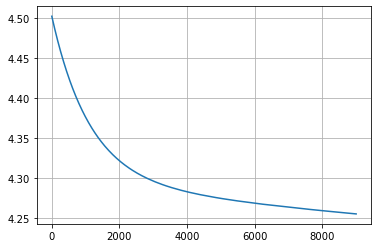

In [67]:
plt.plot(tf.reduce_mean(chi[1000:,:,0],axis=1))
plt.grid()

(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)


Text(0.5, 1.0, 'chi_T')

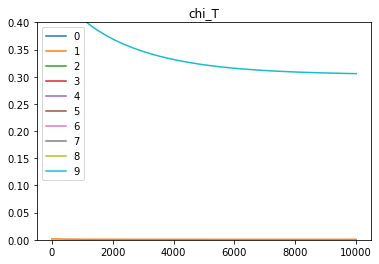

In [69]:
for i in range(10):
    print(np.array(chi).shape)
    plt.plot(chi[:,i,0],label=str(i))
    plt.ylim(0,0.4)
plt.legend()
plt.title('chi_T')

(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)


Text(0.5, 1.0, 'S_X')

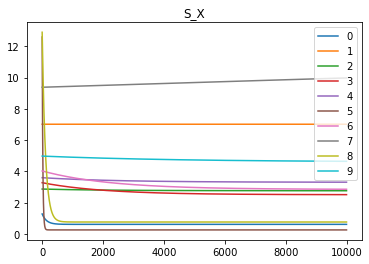

In [71]:
for i in range(0,10):
    print(np.array(chi).shape)
    plt.plot(params[:,i,-1],label=str(i))
plt.legend()
plt.title('S_X')

(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)
(10000, 10, 1)


Text(0.5, 1.0, 't0')

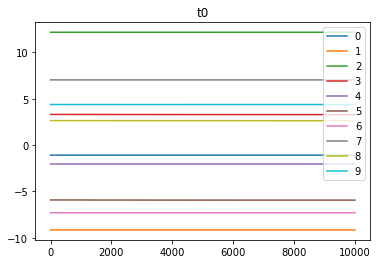

In [72]:
for i in range(10):
    print(np.array(chi).shape)
    plt.plot(params[:,i,0],label=str(i))
plt.legend()
plt.title('t0')

In [73]:
theta_r = ev_params[:10,2]/180*math.pi


Text(0.5, 1.0, 'theta')

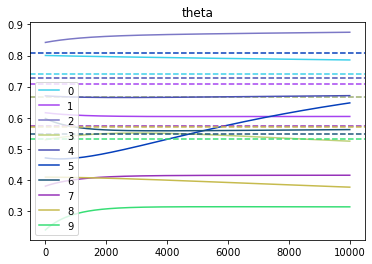

In [74]:
for i in range(10):
    c=np.random.rand(3)
    plt.plot(params[:,i,1],label=str(i),c=c)
    plt.axhline(y = theta_r[i], color =c, linestyle = '--') 
plt.legend()
plt.title('theta')

Text(0.5, 1.0, 'phi')

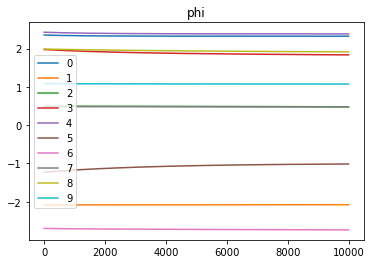

In [75]:
for i in range(10):
    plt.plot(params[:,i,2],label=str(i))
plt.legend()
plt.title('phi')

(10001, 10, 7)
(10001, 10, 7)
(10001, 10, 7)
(10001, 10, 7)
(10001, 10, 7)
(10001, 10, 7)
(10001, 10, 7)
(10001, 10, 7)
(10001, 10, 7)
(10001, 10, 7)


Text(0.5, 1.0, 'courve')

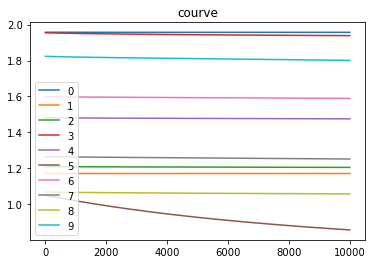

In [76]:
for i in range(10):
    print(params[:].shape)
    plt.plot(params[:,i,3],label=str(i))
plt.legend()
plt.title('courve')

In [57]:
ev_params[20:40,2:4] 

array([[ 35.3505 , 110.117  ],
       [ 32.0455 , 332.741  ],
       [ 31.4524 , 334.699  ],
       [ 30.2315 , 294.016  ],
       [ 33.0698 , 253.295  ],
       [ 32.457  , 301.215  ],
       [ 34.105  , 138.855  ],
       [ 31.8346 ,   8.54537],
       [ 32.7883 , 283.106  ],
       [ 36.9185 , 230.656  ],
       [ 34.8607 , 108.764  ],
       [ 31.14   , 171.404  ],
       [ 34.4091 , 322.173  ],
       [ 33.5278 ,   4.13313],
       [ 33.0801 , 181.94   ],
       [ 29.9834 ,  74.079  ],
       [ 35.8023 , 293.769  ],
       [ 31.876  ,  25.2436 ],
       [ 33.4199 , 263.276  ],
       [ 33.2462 , 216.394  ]], dtype=float32)

In [77]:
ang_res=tf.concat([rec.theta*180/3.14,tf.where(rec.phi*180/3.14>0,rec.phi*180/3.14,(rec.phi+3.14*2)*180/3.14)],axis=1)
ang_res.shape

TensorShape([10, 2])

In [50]:
#Befor chi_L
diff= tf.reduce_mean(tf.math.abs(ev_params[20:40,2:4] -ang_res),axis=0)
print(diff)
print(tf.math.reduce_std(ev_params[20:40,2] -ang_res[:,0]),tf.math.reduce_std(ev_params[20:40,3] -ang_res[:,1]))

tf.Tensor([ 6.708931 14.361145], shape=(2,), dtype=float32)
tf.Tensor(9.405685, shape=(), dtype=float32) tf.Tensor(22.320835, shape=(), dtype=float32)


In [59]:
# after
diff= tf.reduce_mean(tf.math.abs(ev_params[:2000,2:4] -ang_res),axis=0)
print(diff)
print(tf.math.reduce_std(ev_params[:2000,2] -ang_res[:,0]),tf.math.reduce_std(ev_params[:2000,3] -ang_res[:,1]))

tf.Tensor([ 7.682284 30.26008 ], shape=(2,), dtype=float32)
tf.Tensor(13.246112, shape=(), dtype=float32) tf.Tensor(75.840805, shape=(), dtype=float32)


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  5.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.

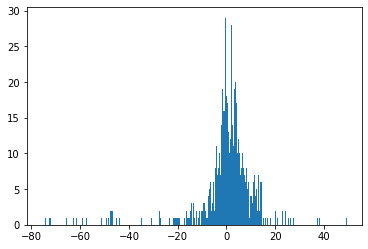

In [63]:
plt.hist(ev_params[:2000,2] -ang_res[:,0],bins=1000)

In [3]:
num = 64
h5f = '../../mc_hadrons_qgs34_0010.h5'
h5f = '/home3/ivkhar/TA/data/mass_spectrum/old_1223/hadrons/bundled/mc_hadrons_qgs34_0010.h5'
with h5py.File(h5f,'r') as hf:
    times_flat = hf['pr-q4-9yr/dt'][:num,:,:,4:5]*1e6 # in mks
    times_diff = hf['pr-q4-9yr/dt'][:num,:,:,5:6]*1e6 # in mks
    mask = hf['pr-q4-9yr/dt'][:num,:,:,6:7]
    real_coords = hf['pr-q4-9yr/dt'][:num,:,:,:3] # in 1.2*km
    qs = hf['pr-q4-9yr/dt'][:num,:,:,3:4]
    ev_params = hf['pr-q3-9yr/ev_params'][:num]
    
times_reg = times_flat + times_diff
mask_qs = tf.where( tf.math.logical_and(mask>0, qs>0), 1., 0. )
xs = tf.expand_dims( tf.linspace( 0., 5*1.2, 6 ), axis=-1 )
xs = tf.repeat(xs, 6, axis=1)
ys = tf.transpose( xs )
coords = tf.expand_dims( tf.stack( (xs,ys), axis=-1 ), axis=0 ) # in km
c = tf.constant(0.299792458, dtype=tf.float32) # in km\mks
# prepare matricies to solve
def make_matrix(coords, times_reg, mask):
    
    # matrix for dL/db
    hs = tf.ones((1,6,6,1)) # to make (x_1,x_2) -> (x_1,x_2,1), to account for b
    coords_ext = mask*tf.concat( (coords,hs), axis=-1 ) # (bs,6,6,3)
    matrix_b = tf.expand_dims( tf.math.reduce_sum( coords_ext, axis=(1,2) ), axis=-1 ) # (bs,6,6,3,1)
    times = mask*times_reg # (bs,6,6,1)
    rhs_b = tf.math.reduce_sum( times, axis=(1,2) ) # (bs,1)
    
    # matrix for dL/da
    coords_mul = tf.expand_dims( coords_ext, axis=-1) * tf.expand_dims( coords, axis=-2)
    matrix_a = tf.math.reduce_sum( coords_mul, axis=(1,2) ) # (bs,6,6,3,2)
    ts_mul = times * coords
    rhs_a = tf.math.reduce_sum( ts_mul, axis=(1,2) )
    
    matrix = tf.concat((matrix_b,matrix_a), axis=-1)
    rhs = tf.expand_dims( tf.concat((rhs_b,rhs_a), axis=-1), axis=-1 )
    
    return matrix, rhs
def lin_solve(matrix, rhs):
    sol_flat = tf.linalg.solve( matrix, rhs, adjoint=True )[:,:,0]
    print(sol_flat)
    t0 = sol_flat[:,2]
    # extract parameters
    n_z = 1/c/c - tf.math.reduce_sum(sol_flat[:,:2]*sol_flat[:,:2], axis=1)
    n_z = tf.where( n_z>0, tf.math.sqrt( n_z ), 0. ) # some configurations yield front moving faster than light
    print('n_z',n_z)
    theta_flat = tf.math.acos( n_z*c )
    phi_flat = tf.math.atan2( sol_flat[:,1], sol_flat[:,0] )
    
    return theta_flat, phi_flat, t0
matrix, rhs = make_matrix(coords, times_reg, mask)
sol_flat=lin_solve(matrix, rhs)
theta, phi, t0 = lin_solve(matrix, rhs) # (bs,)
phi/3.14*180


tf.Tensor(
[[  1.690568    -1.6945748   -1.0818156 ]
 [  0.9904436    1.678957    -9.411423  ]
 [ -2.192621    -1.1778892   12.180873  ]
 [  0.66441846  -1.5473608    3.3125598 ]
 [  1.5665901   -1.3564273   -2.033852  ]
 [ -0.50638616   1.4255589   -5.9170237 ]
 [  1.693558     0.80760324  -7.2979884 ]
 [ -1.1613629   -0.44394162   7.119641  ]
 [  0.539285    -1.2119058    2.6467204 ]
 [ -0.36687446  -0.6997201    4.3824077 ]
 [ -0.8971767   -0.7005648    6.763143  ]
 [  0.8620558   -1.7710629    4.004331  ]
 [  1.486538     1.1685897   -8.332845  ]
 [  0.44323626  -1.4122609    5.4817886 ]
 [ -1.2110292   -0.6453041    9.464282  ]
 [ -0.47500038   1.054167    -1.446     ]
 [ -1.126339    -1.322737     9.62021   ]
 [ -1.9163822    0.02383728   8.648997  ]
 [ -0.8919314    1.9643096   -1.9128022 ]
 [  0.8607137    1.9327376   -7.716711  ]
 [  0.58633155  -1.741169     4.4970164 ]
 [ -1.4055791    0.8666418    3.4287083 ]
 [ -1.594655     1.0198795    2.3299828 ]
 [ -0.32000008   0.8293

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ -45.090675 ,   59.493122 , -151.83202  ,  -66.795746 ,
        -40.908295 ,  109.61158  ,   25.507902 , -159.16087  ,
        -66.04494  , -117.72843  , -142.08736  ,  -64.07822  ,
         38.190773 ,  -72.61241  , -152.02588  ,  114.31395  ,
       -130.48126  ,  179.37828  ,  114.47934  ,   66.028435 ,
        -71.42547  ,  148.41838  ,  147.47336  ,  111.154564 ,
         99.09006  ,  111.39848  ,  -38.16081  , -173.6324   ,
        152.98344  ,   44.788975 ,  -45.31987  ,  -15.201984 ,
        138.35306  , -160.82552  ,   20.068356 ,  -95.30713  ,
         71.44137  , -154.94284  ,  107.48643  ,   48.002686 ,
          4.0393744,  -55.981457 ,  133.64186  , -174.19273  ,
         71.1309   ,  130.7888   ,  116.42755  ,  -37.481594 ,
         11.4989195,   85.55882  ,    1.0422605,  138.42151  ,
         57.84859  , -141.22237  ,   13.51256  ,  -13.543718 ,
       -105.87633  ,  178.18668  , -165.66962  ,  -29.445803 ,
        

In [162]:
sol[:2]

<tf.Tensor: shape=(2, 3, 1), dtype=float32, numpy=
array([[[-1.6945673 ],
        [ 1.690574  ],
        [-1.0818663 ]],

       [[ 1.6789589 ],
        [ 0.99045706],
        [-9.411484  ]]], dtype=float32)>

In [160]:
t0_ext = t0[:,tf.newaxis,tf.newaxis]
nx = 1/c*tf.math.sin(theta)[:,tf.newaxis,tf.newaxis] * tf.math.cos(phi)[:,tf.newaxis,tf.newaxis]
ny = 1/c*tf.math.sin(theta)[:,tf.newaxis,tf.newaxis] * tf.math.sin(phi)[:,tf.newaxis,tf.newaxis]
a = tf.concat((nx,ny), axis=-1)
a = tf.expand_dims( a, axis=1 )

t_rec = t0_ext + tf.math.reduce_sum( a*coords, axis=-1 )
t_rec = t_rec*mask[:,:,:,0]
times_flat[:,:,:,0]*mask[:,:,:,0]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -3.593     ,
         -5.576     ,  0.        ],
        [ 0.        ,  0.        ,  0.325     , -1.714     ,
         -3.748     ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.125     ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  3.8920002 ,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -1.665     ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -2.3170002 , -0.62      ,
          1.778     ,  0.        ],
        [ 0.        ,  0.   